# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import os
import openpyxl
import xlrd
from functools import reduce
import datetime

# Import Data Files

In [2]:
file = (r'c:/Users/pjant/Desktop/Machine-Learning-Python/Dataset.xlsx')
sheet_name = ('Data Table Training')

In [3]:
df_swapIV = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','IV'), usecols=(1,2))
df_swapRates = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','Rates'), usecols=(4,5) )
df_swapHV = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date', 'HV'), usecols=(4,6))
df_VIX = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date', 'VIX'), usecols=(8,9))
df_curve = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','Curve'), usecols=(11,12))
df_SPX = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','SPX'), usecols=(14,15))
df_SPXHV = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','SPXHV'), usecols=(14,16))
df_CDXHY = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','CDXHY'),usecols=(18,19))
df_Spreads = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','Spreads'),usecols=(21,22))
df_HYG = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','HYG'),usecols=(25,26))

# Create Data Frame

In [4]:
data_frames = [df_swapIV, df_swapRates, df_swapHV, df_VIX, df_curve, df_SPX, df_SPXHV, df_Spreads, df_HYG]

In [5]:
for i in data_frames:
    i = i.set_index('Date', inplace=True)

In [6]:
df = reduce(lambda  left,right:pd.merge(left,right,left_index=True,right_index=True),data_frames)

In [7]:
df = df.fillna(method='ffill')

# Examine Data

In [8]:
df.tail()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
Date,,,,,,,,,
2020-05-13,66.6914,0.6162,0.451336,35.28,0.3647,2820.00,27.282796,-3.63,78.87
2020-05-14,66.9021,0.5914,0.457408,32.61,0.3434,2852.50,24.159632,-3.12,78.60
2020-05-15,65.8000,0.6263,0.493792,31.89,0.3559,2863.70,24.083597,-1.88,78.71
2020-05-18,66.8451,0.7080,0.618496,29.30,0.4520,2953.91,24.152846,-1.87,80.10
2020-05-19,66.3517,0.6715,0.654623,30.53,0.4141,2922.94,25.142984,-1.75,80.20


In [9]:
df.corr()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
IV,1.000000,0.541853,0.630112,0.687872,0.477219,-0.687050,0.455239,0.559373,-0.315075
Rates,0.541853,1.000000,0.317926,0.203635,0.380378,-0.455242,0.081110,0.766545,0.226425
HV,0.630112,0.317926,1.000000,0.533382,0.201927,-0.330658,0.334123,0.384989,-0.216264
VIX,0.687872,0.203635,0.533382,1.000000,0.107784,-0.345851,0.542562,0.345855,-0.590719
Curve,0.477219,0.380378,0.201927,0.107784,1.000000,-0.815067,0.078202,0.247546,0.206473
SPX,-0.687050,-0.455242,-0.330658,-0.345851,-0.815067,1.000000,-0.283782,-0.455813,-0.077225
SPXHV,0.455239,0.081110,0.334123,0.542562,0.078202,-0.283782,1.000000,0.161245,-0.428473
Spreads,0.559373,0.766545,0.384989,0.345855,0.247546,-0.455813,0.161245,1.000000,0.337046
HYG,-0.315075,0.226425,-0.216264,-0.590719,0.206473,-0.077225,-0.428473,0.337046,1.000000


In [10]:
df.describe()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
count,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000
mean,91.145949,2.672303,0.839817,19.880933,1.299037,1832.566755,16.108252,10.996423,87.962790
std,31.723963,0.891307,0.546453,9.977835,0.817277,644.764685,14.936407,20.231026,6.090689
min,48.506900,0.591400,0.050724,9.140000,-0.132500,676.530000,0.806088,-18.000000,61.640000
25%,68.163750,2.062625,0.479410,13.550000,0.584125,1310.145000,7.278066,-1.630000,85.690000
50%,81.289550,2.525700,0.711512,16.860000,1.320650,1755.870000,11.928368,8.250000,87.985000
75%,107.422500,3.119725,1.029692,22.510000,1.995500,2296.182500,19.952195,14.750000,91.820000
max,212.650000,5.357000,5.464488,82.690000,2.806600,3386.150000,176.484818,91.290000,106.090000


C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


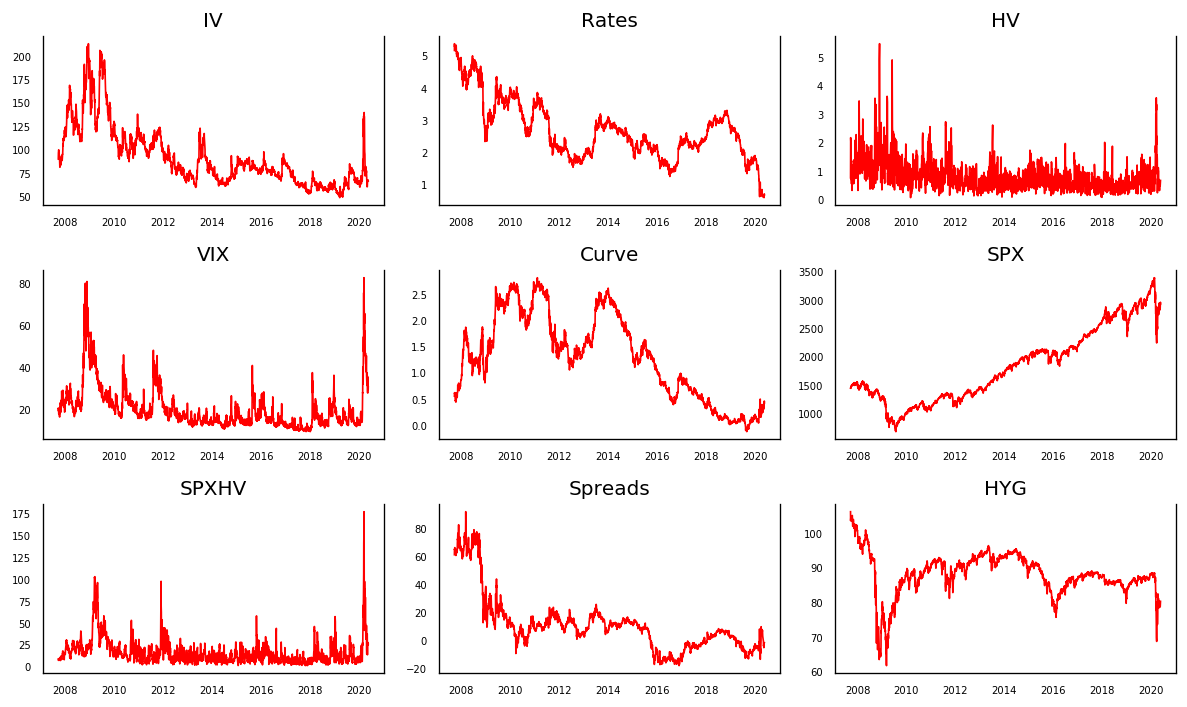

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

In [12]:
df.isna().sum()

IV         0
Rates      0
HV         0
VIX        0
Curve      0
SPX        0
SPXHV      0
Spreads    0
HYG        0
dtype: int64

# Run a Lag Plot on the Raw Data

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

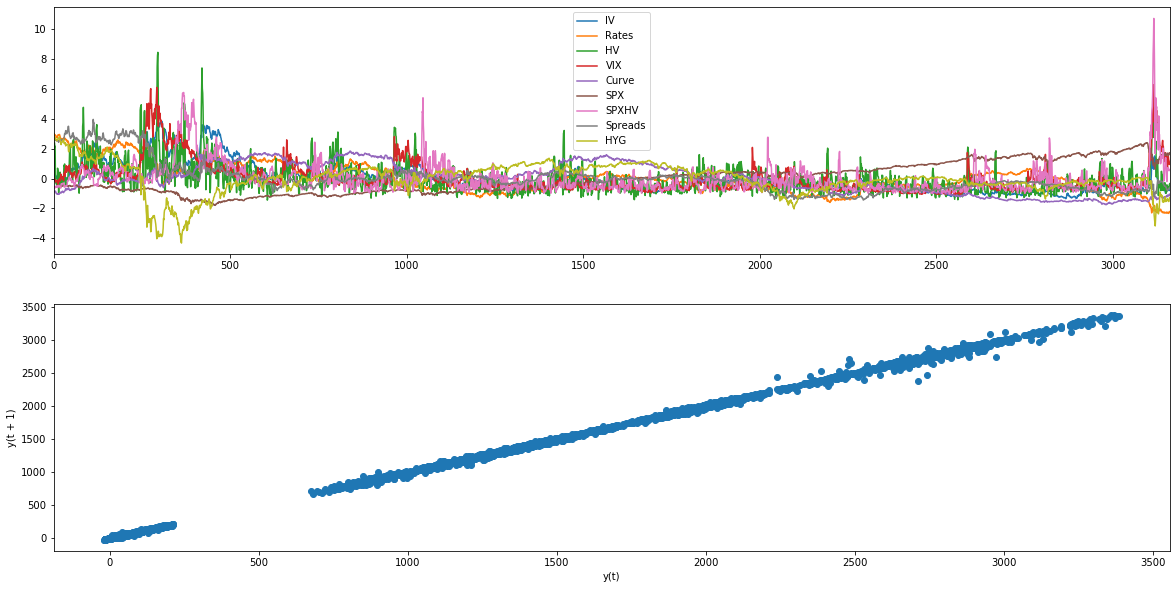

In [14]:
# Is the data Random.  Random data will not exhibit a structure in the lag plot

fig,(ax1,ax2)=plt.subplots(nrows=2, ncols=1, figsize=(20,10))
df_scaled.plot(ax=ax1) # series plot
pd.plotting.lag_plot(df) #lag plot

# Run Autocorrelation Plots on each of the Raw Variables for All Days in the Time Series

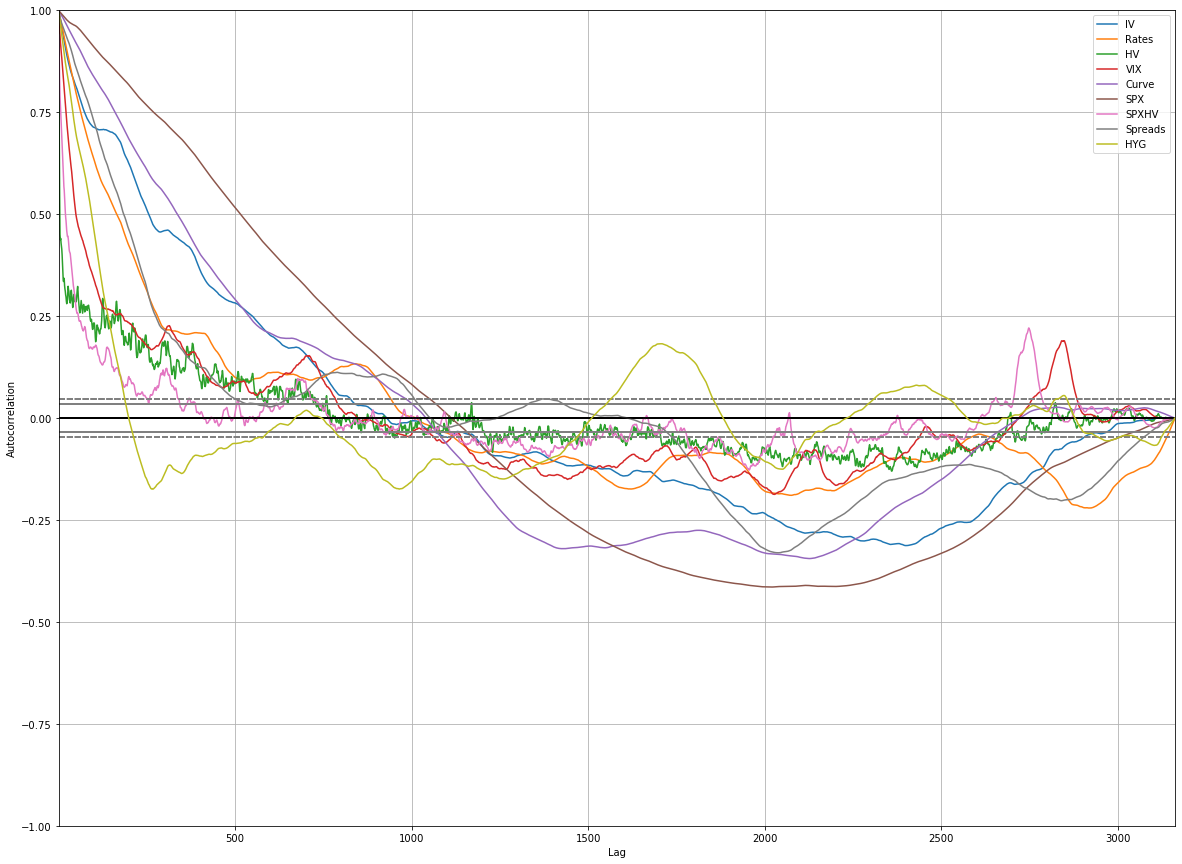

In [15]:
plt.rcParams["figure.figsize"] = (20,15)
pd.plotting.autocorrelation_plot(df.IV, label = 'IV')
pd.plotting.autocorrelation_plot(df.Rates, label = 'Rates')
pd.plotting.autocorrelation_plot(df.HV, label = 'HV')
pd.plotting.autocorrelation_plot(df.VIX, label = 'VIX')
pd.plotting.autocorrelation_plot(df.Curve, label = 'Curve')
pd.plotting.autocorrelation_plot(df.SPX, label = 'SPX')
pd.plotting.autocorrelation_plot(df.SPXHV, label = 'SPXHV')
pd.plotting.autocorrelation_plot(df.Spreads, label = 'Spreads')
pd.plotting.autocorrelation_plot(df.HYG, label = 'HYG')

# Run Autocorrelation and PACF plots for each raw variable for 75 days

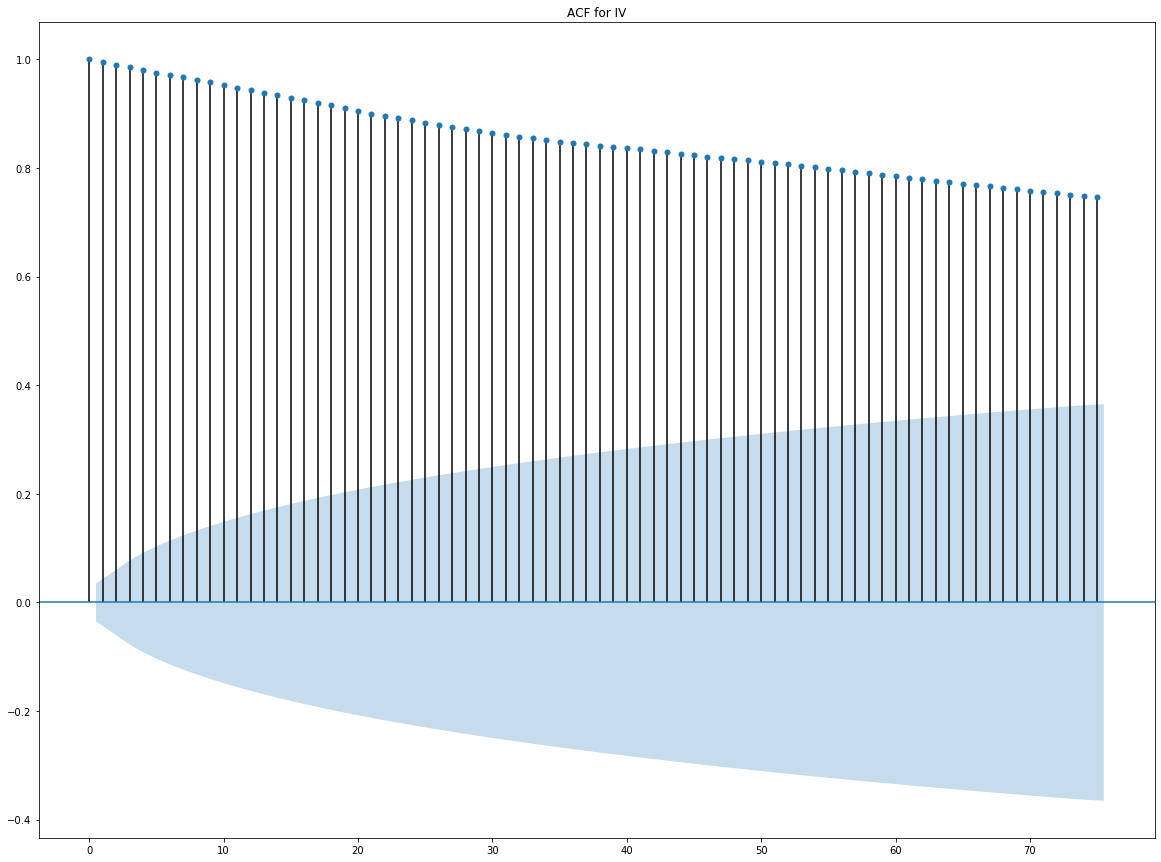

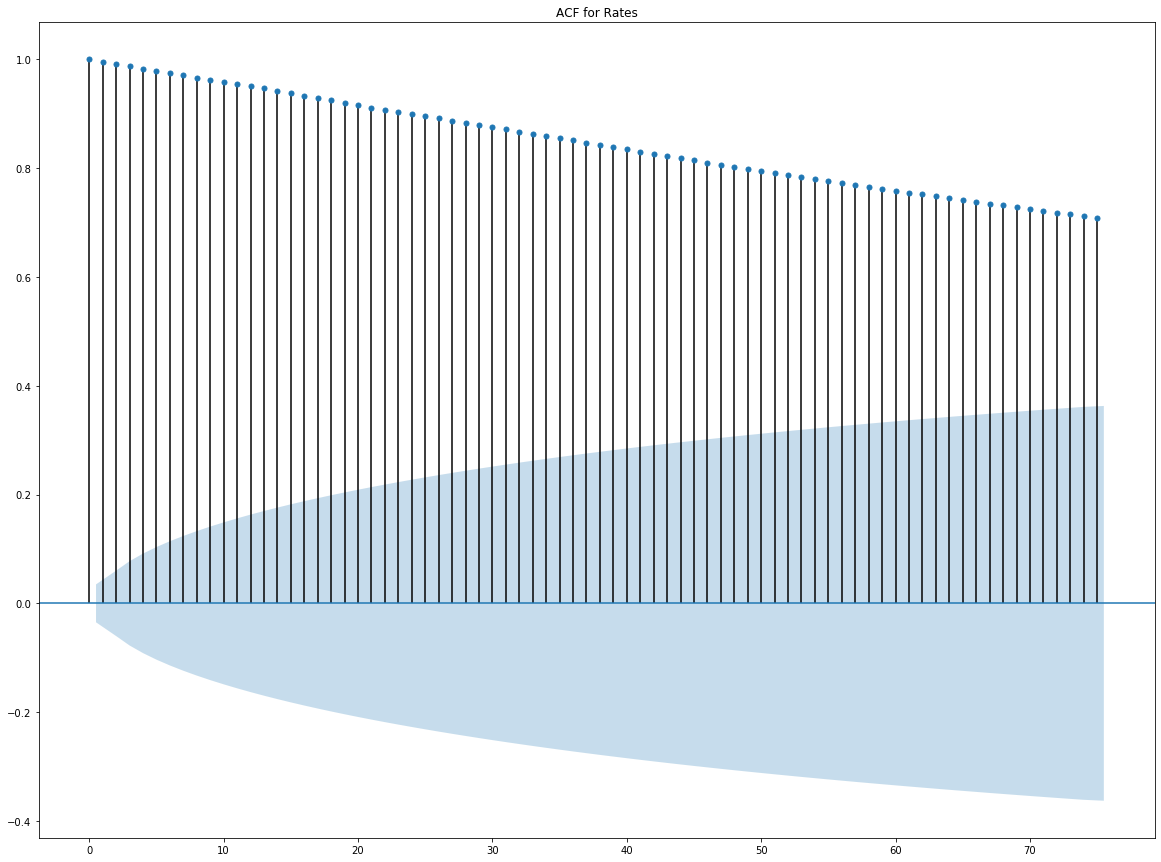

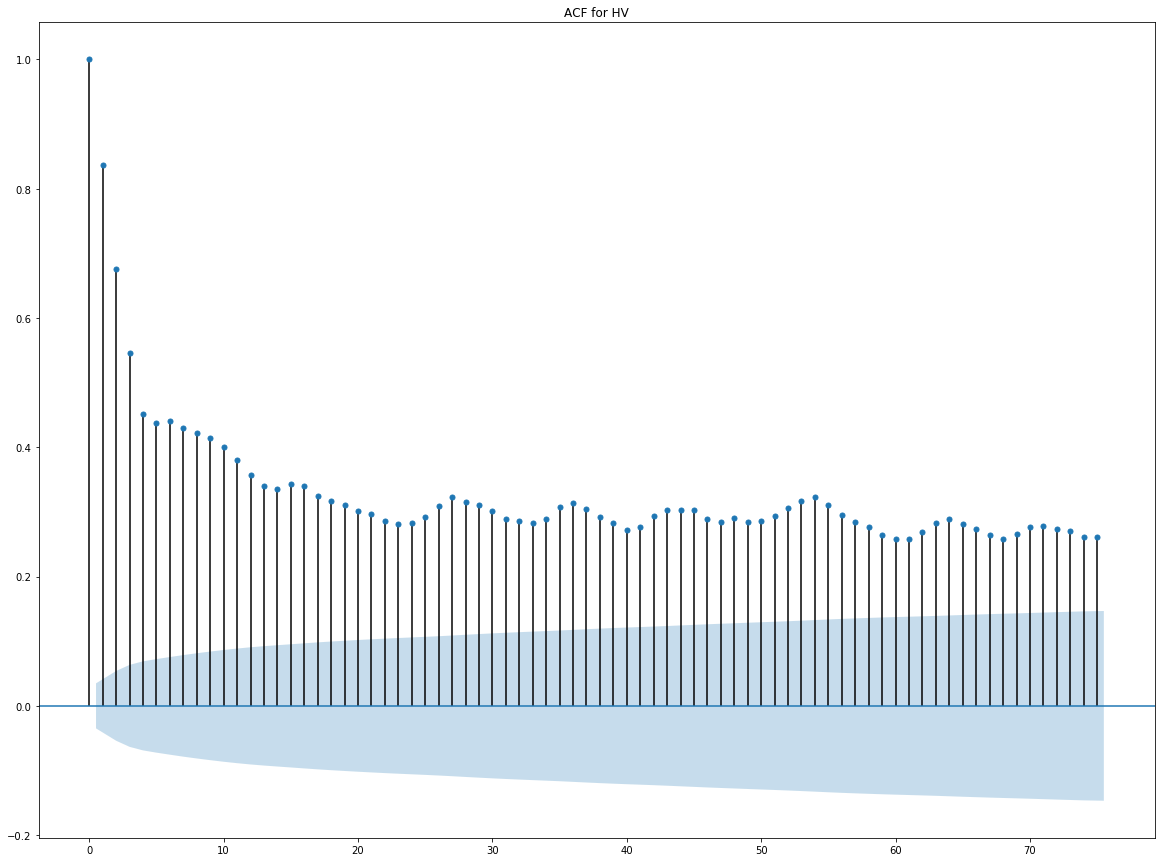

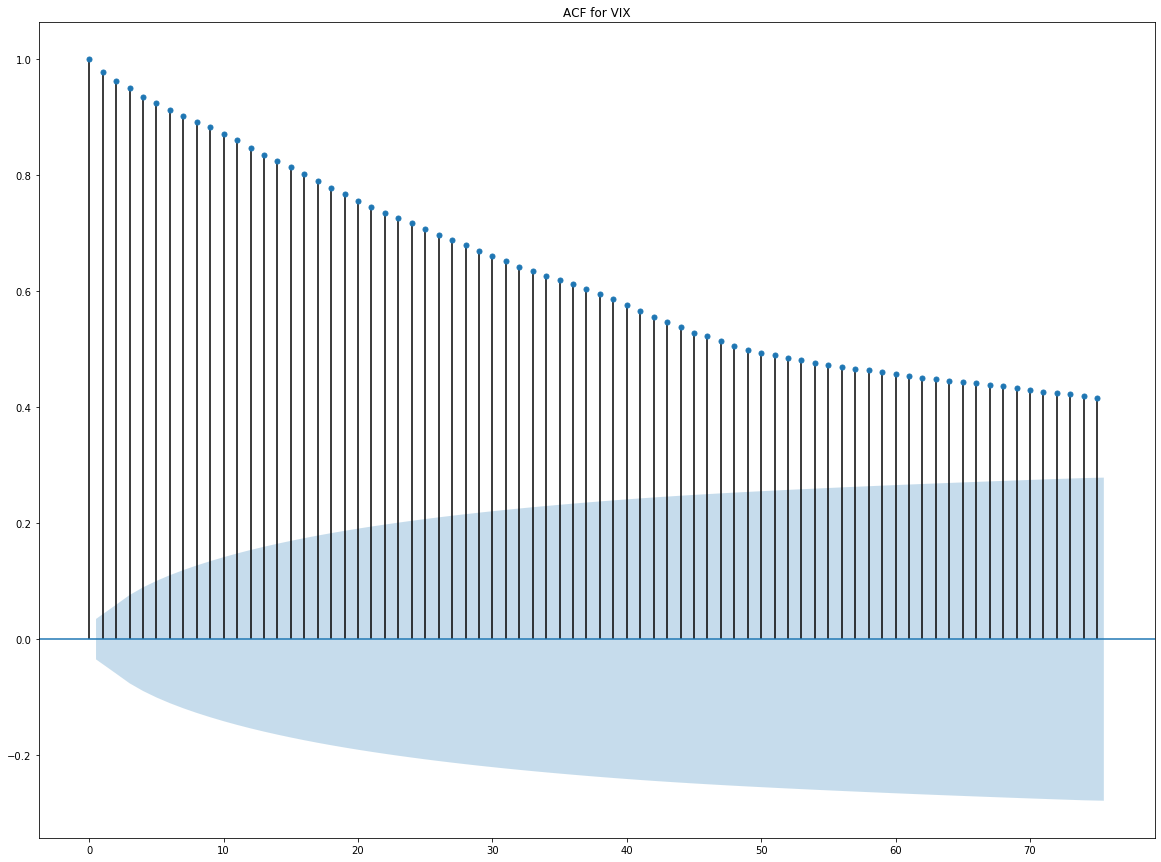

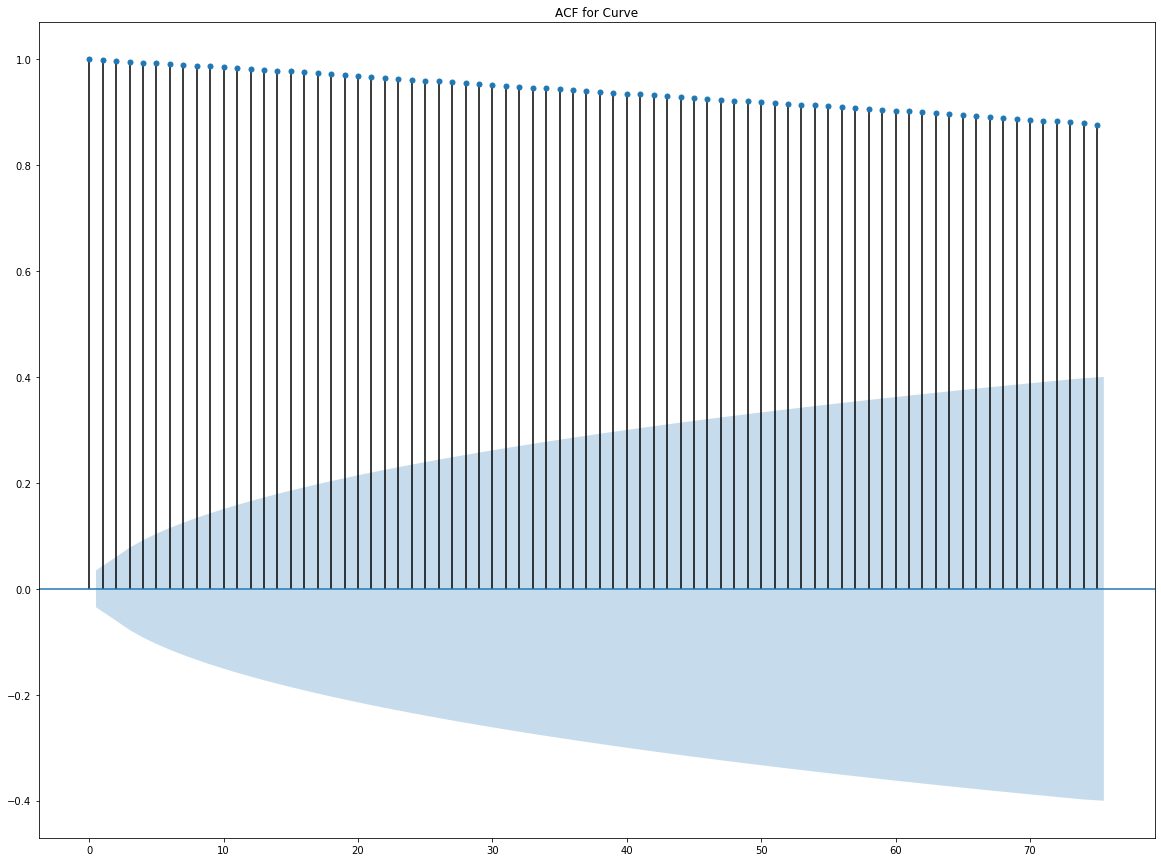

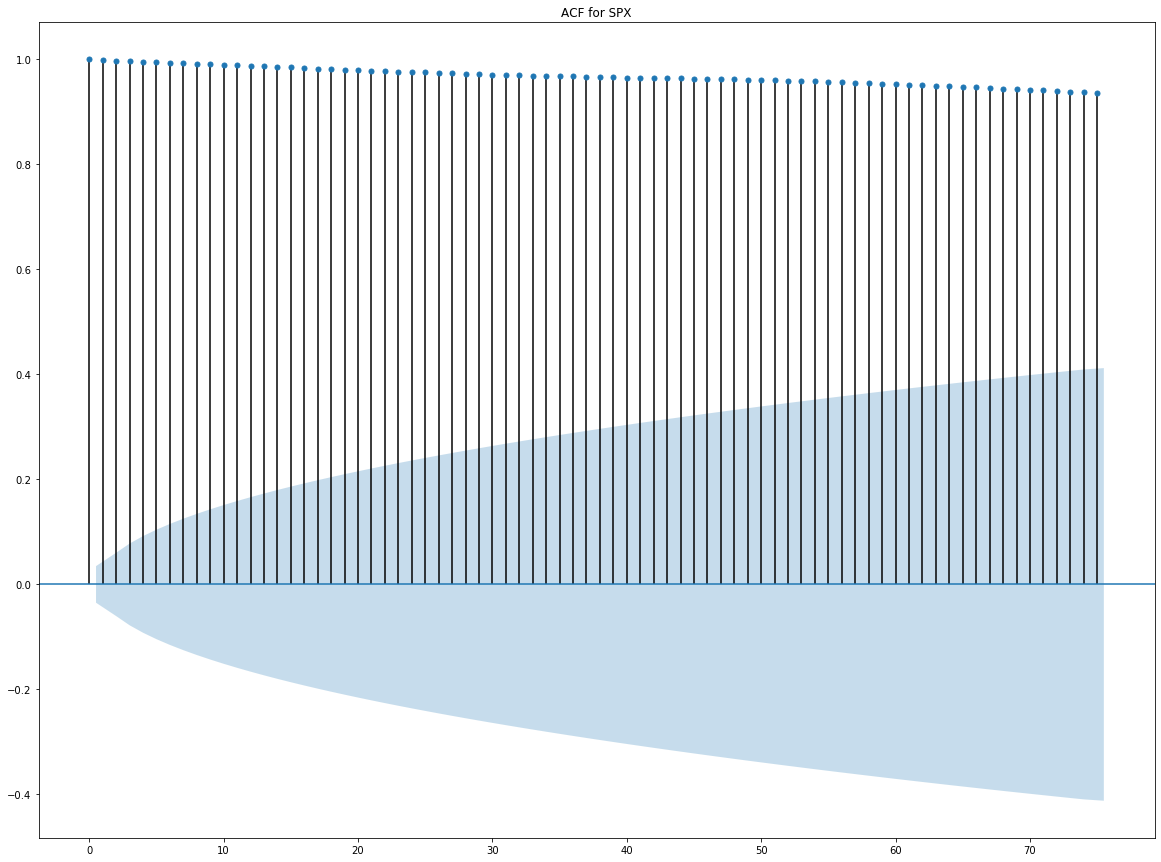

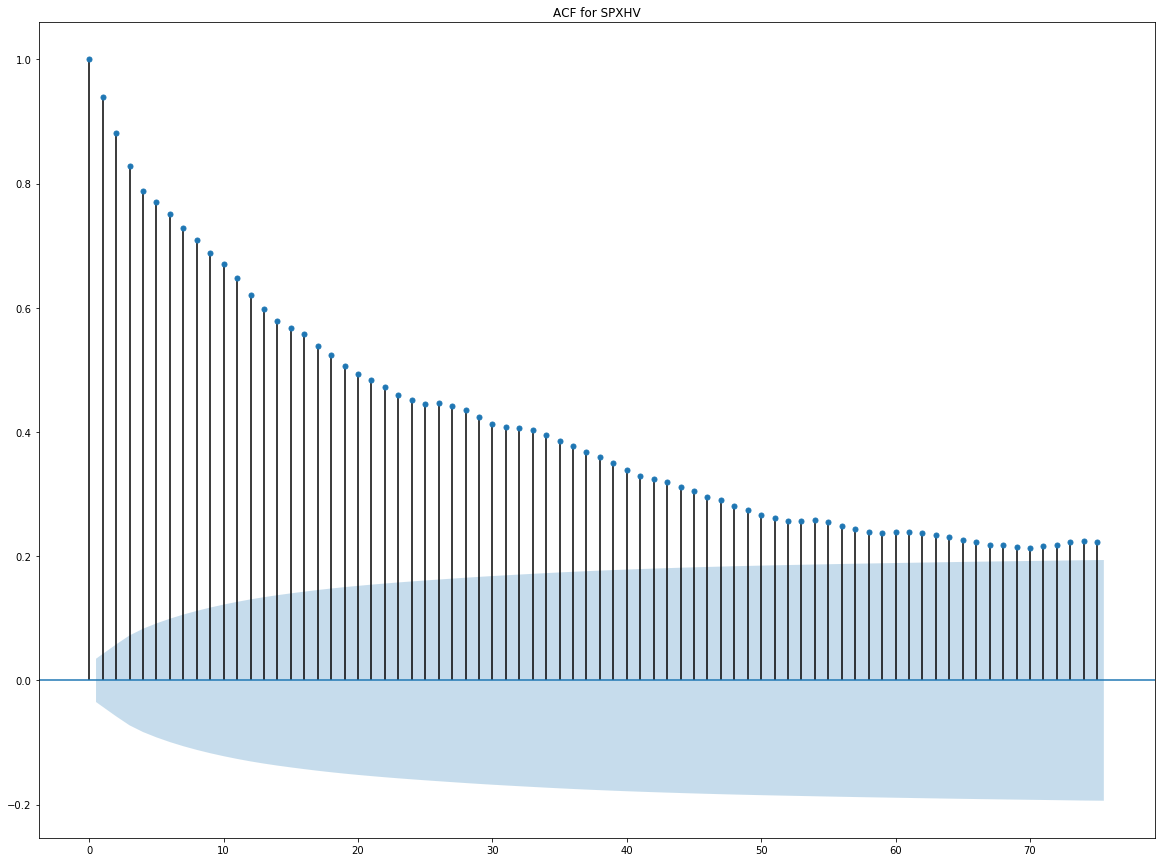

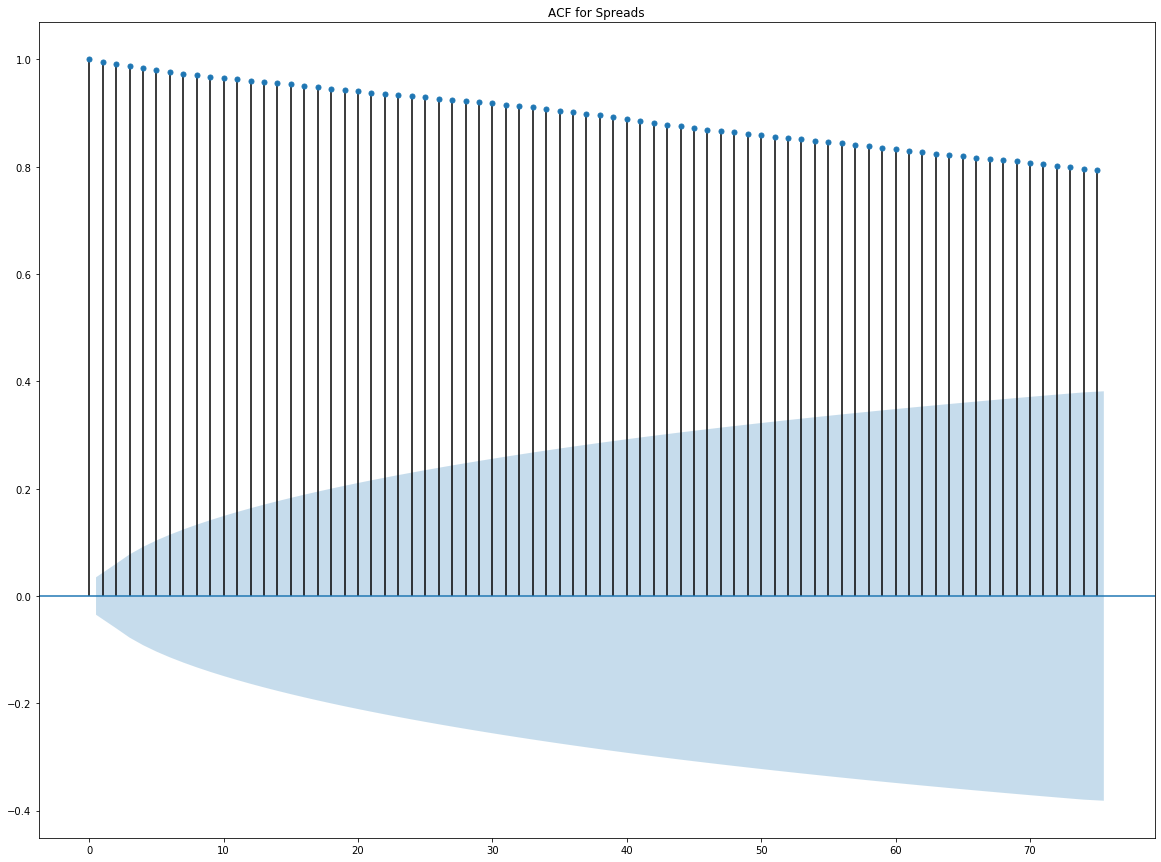

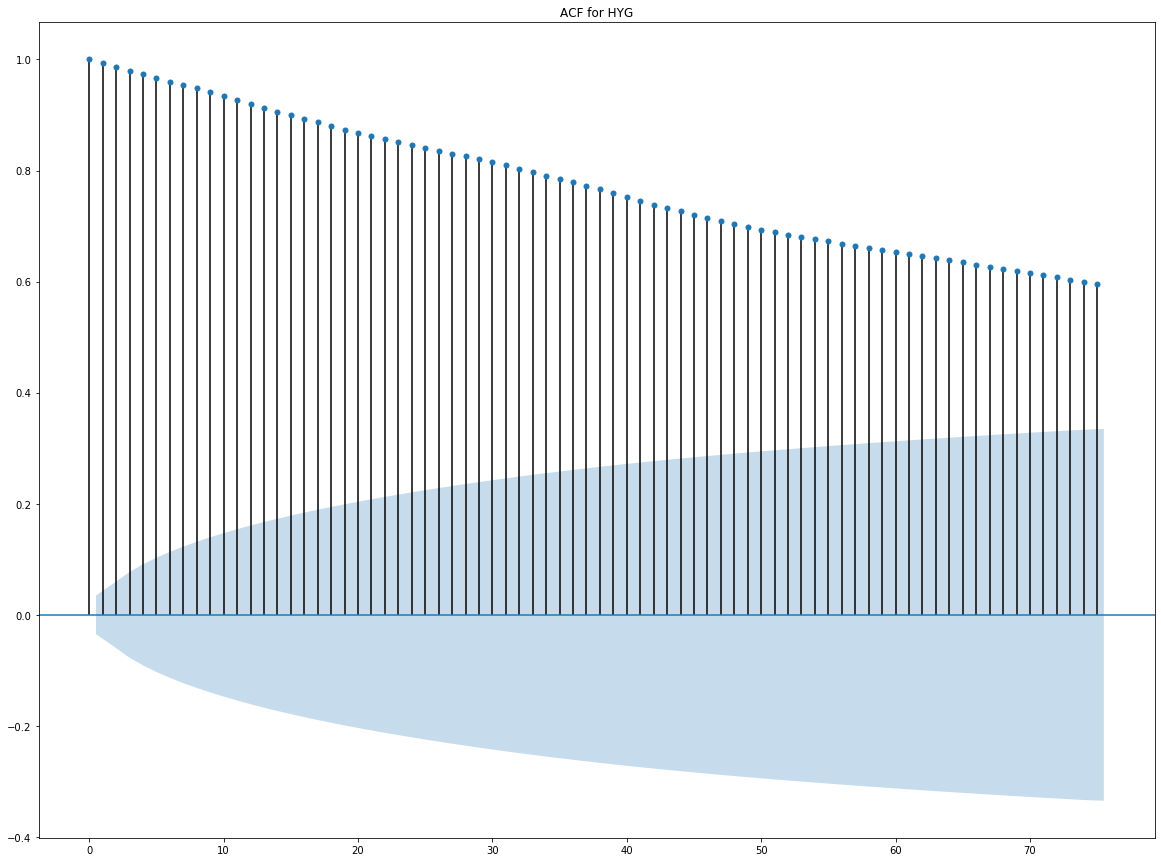

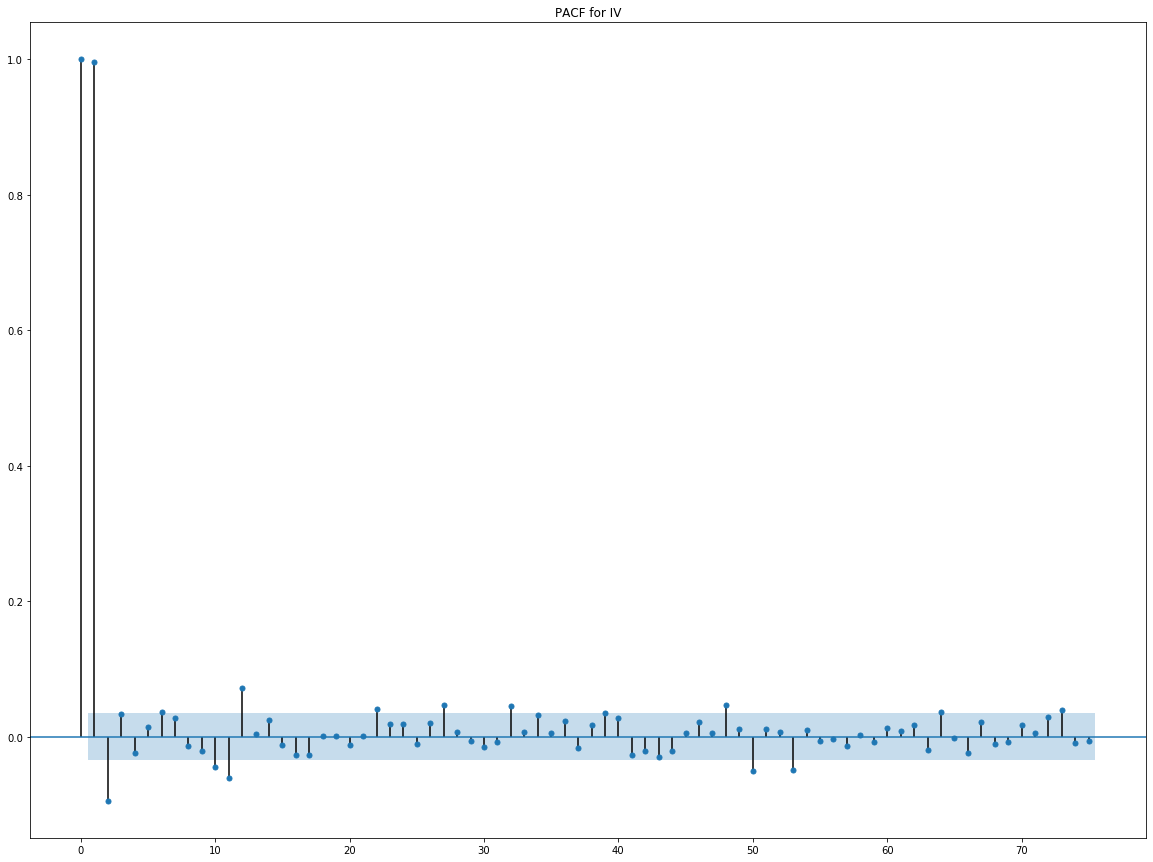

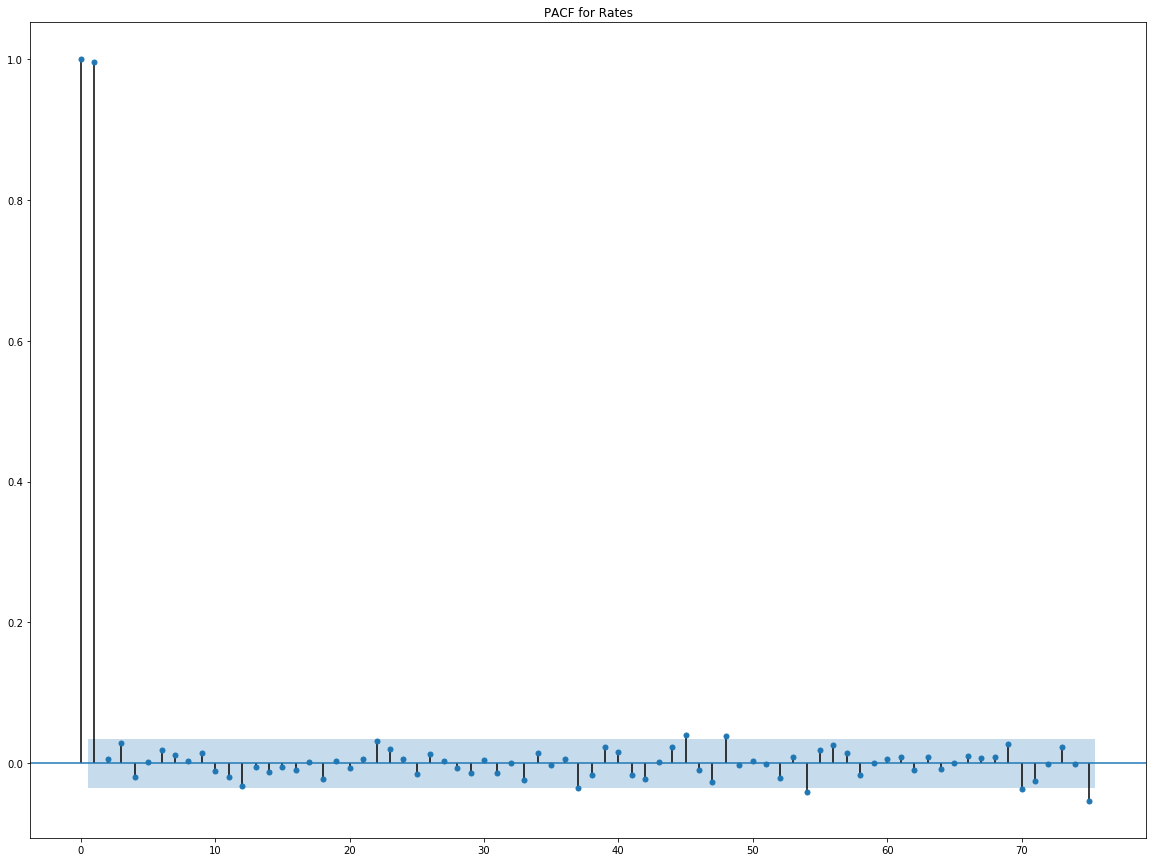

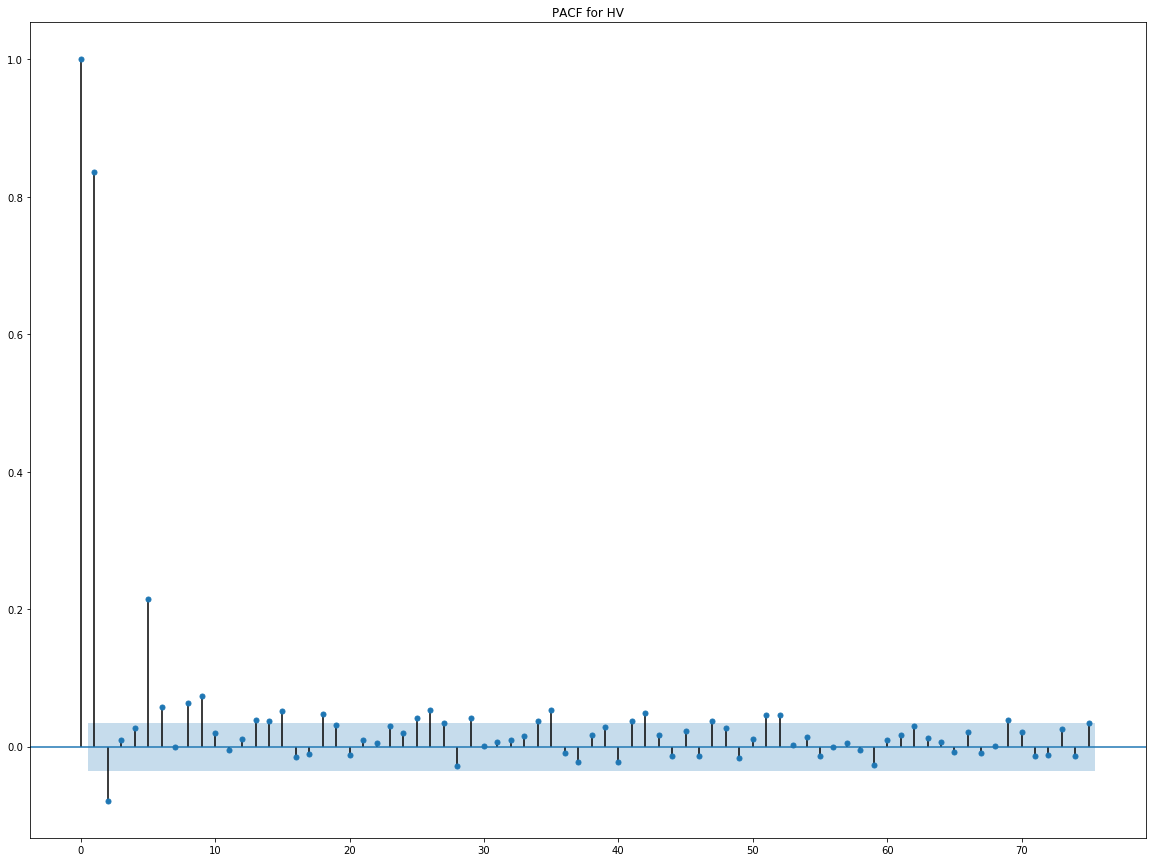

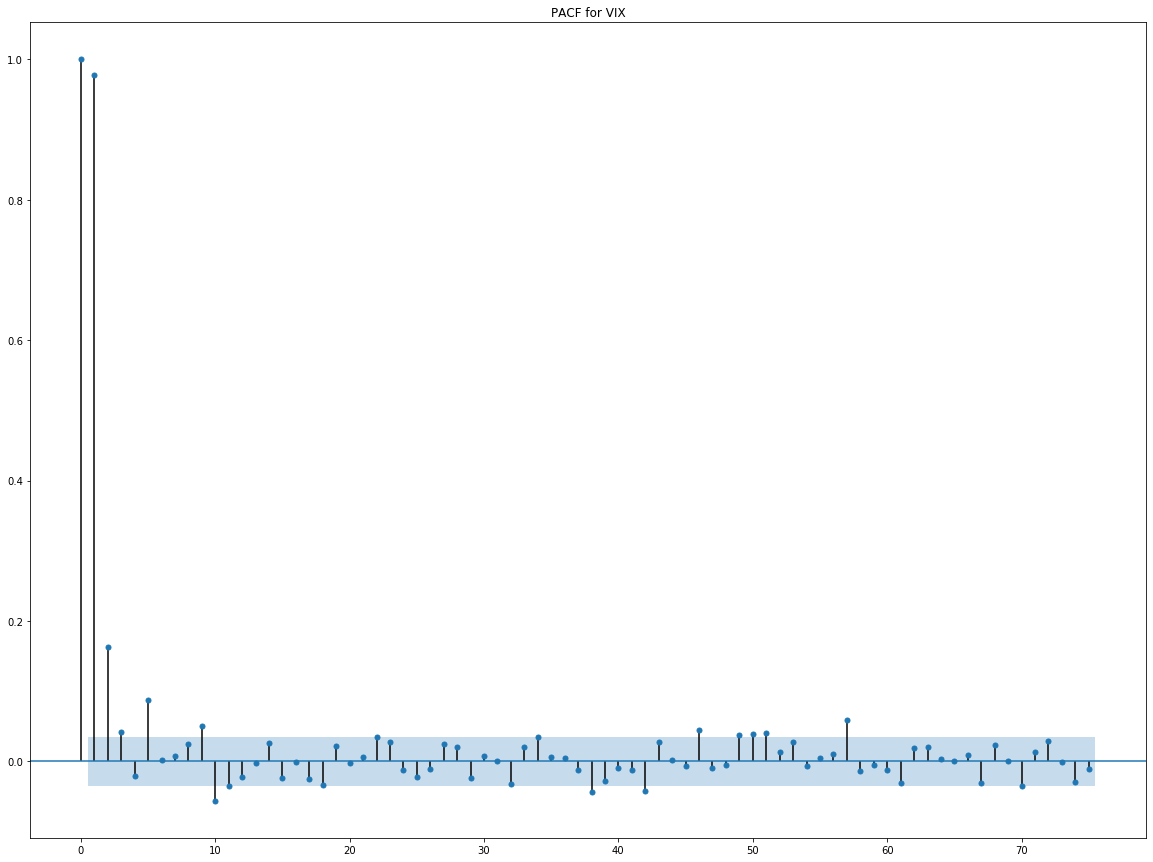

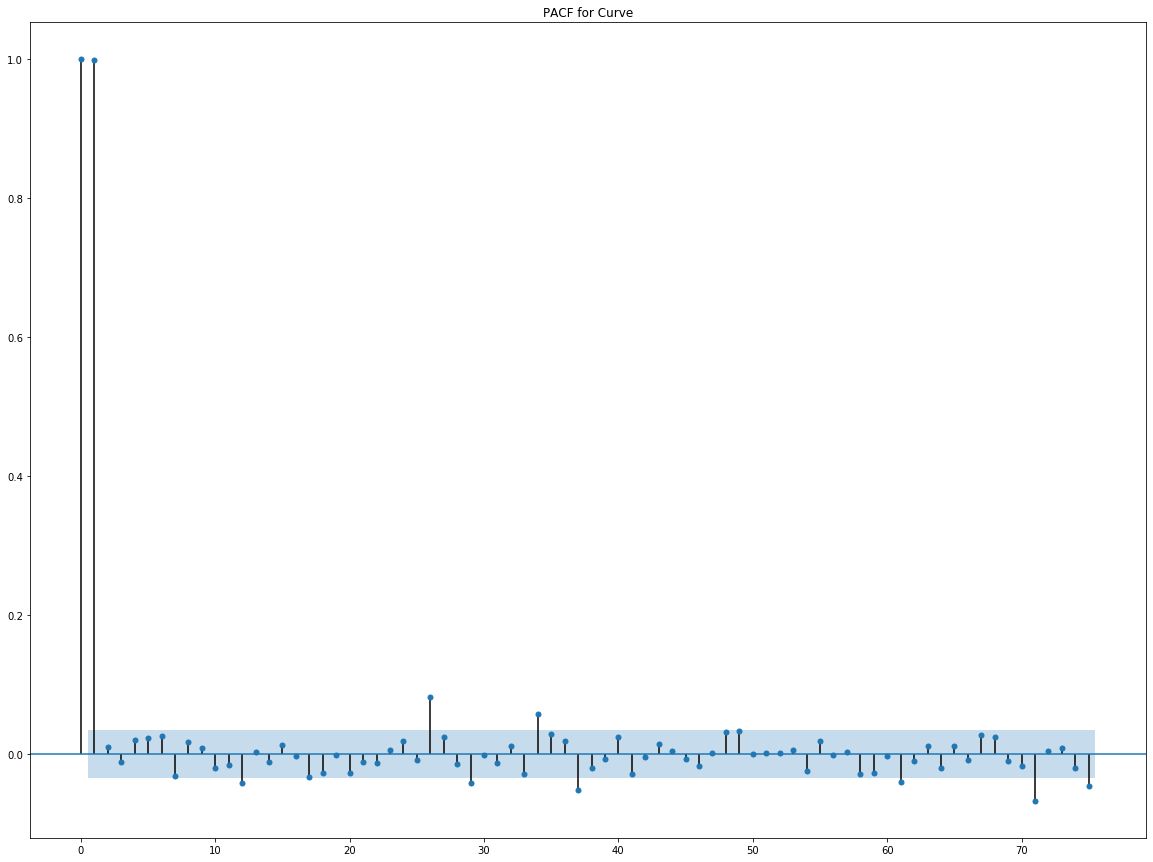

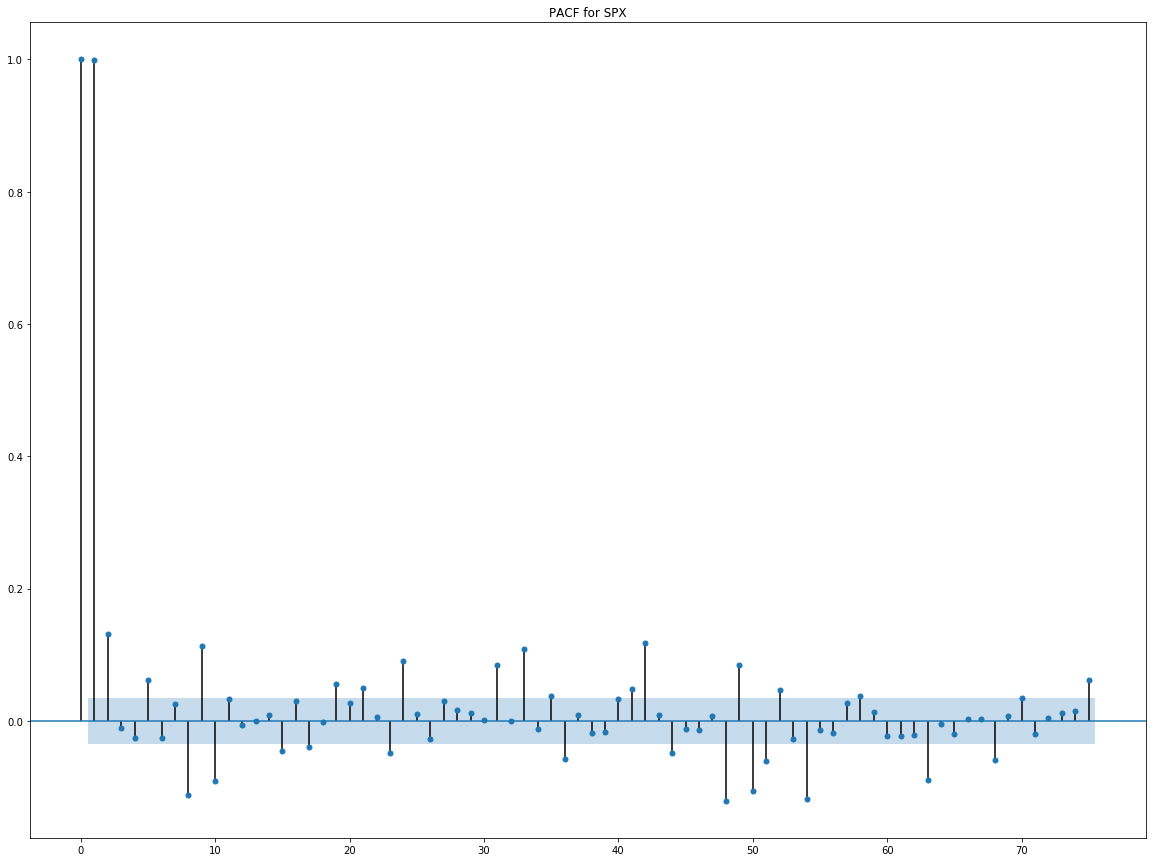

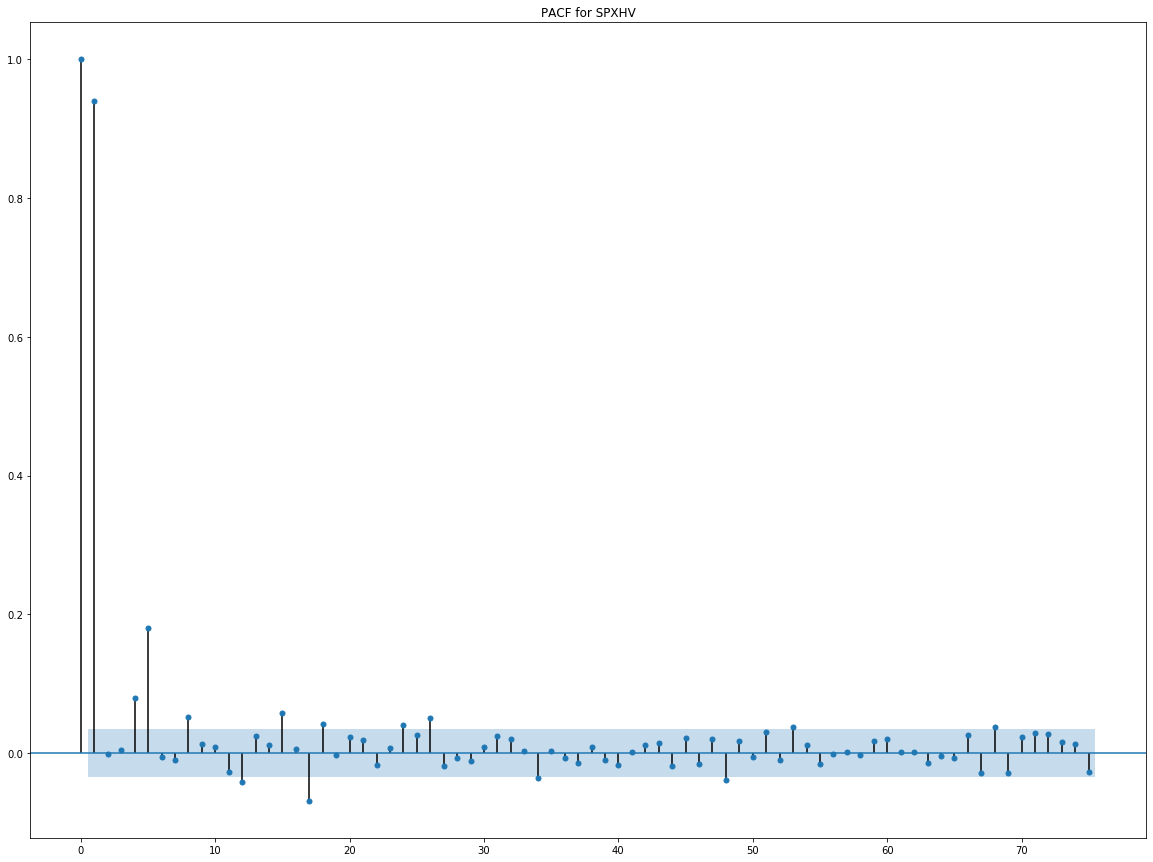

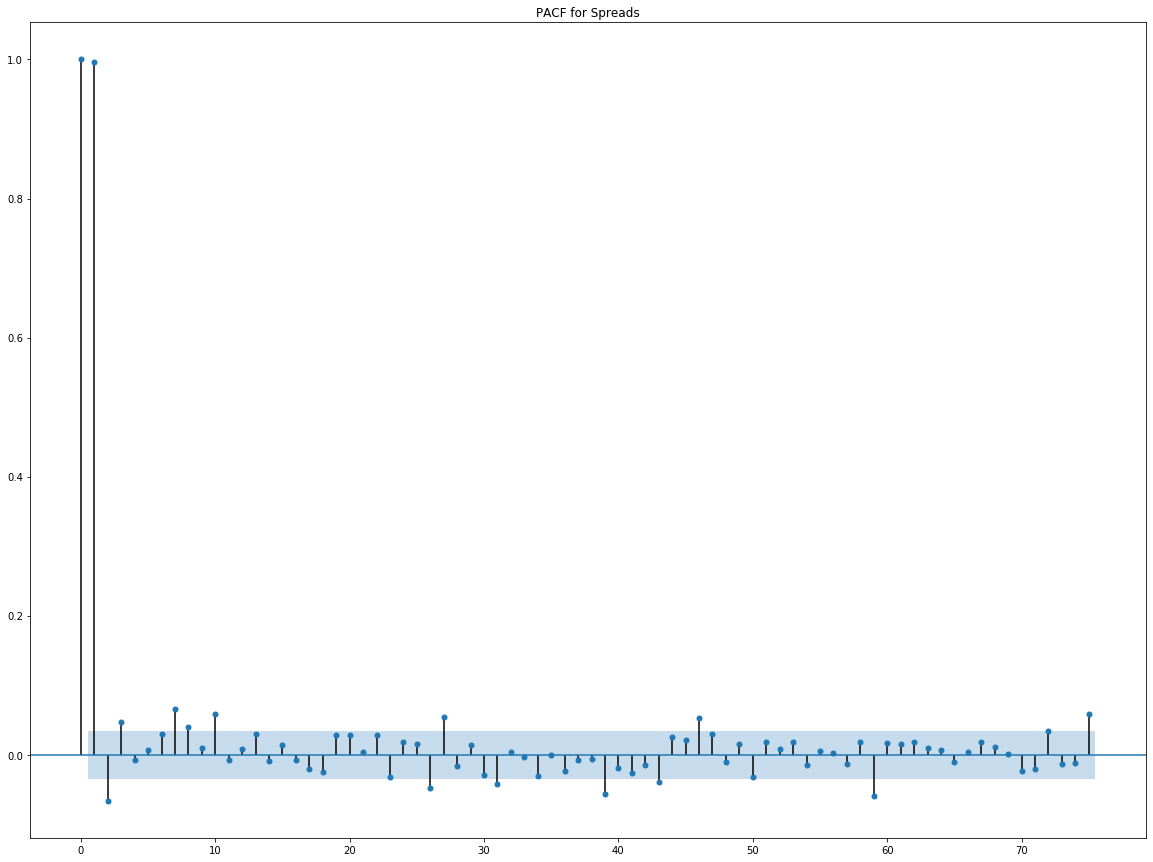

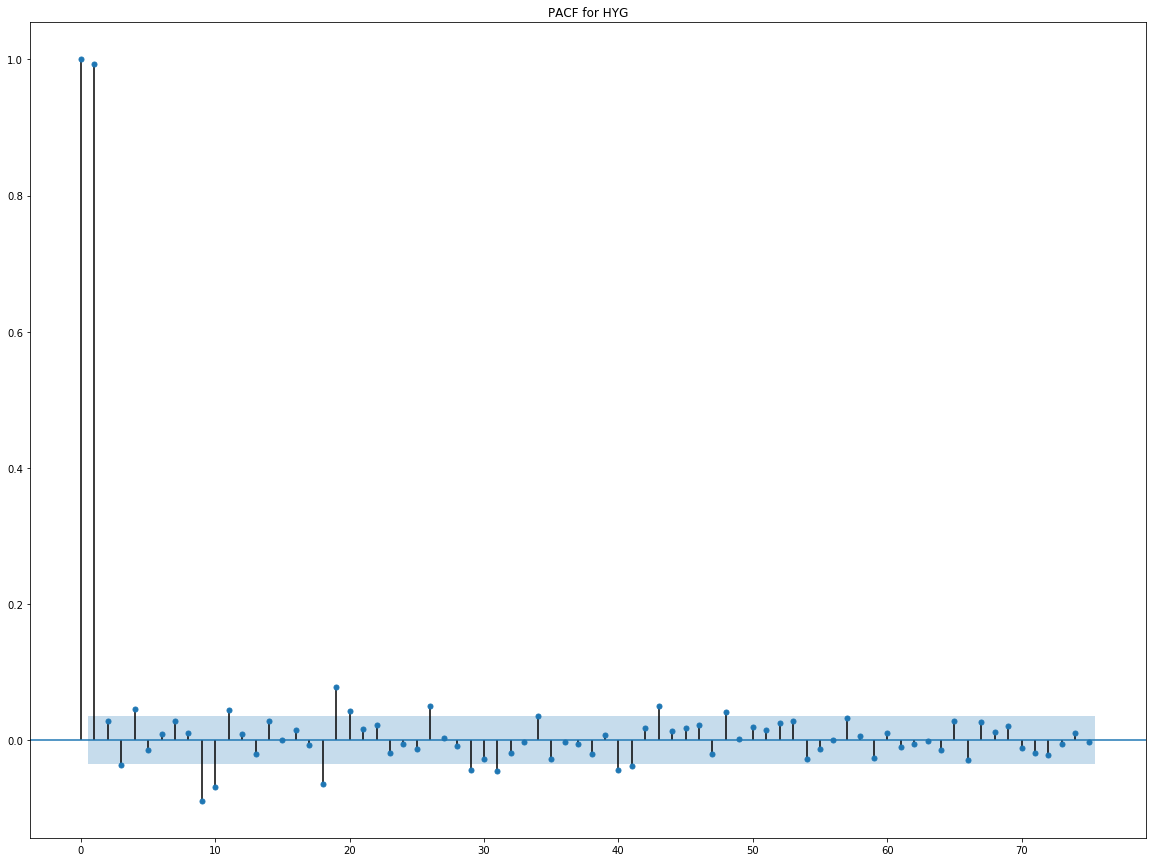

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

for i in df:
    plot_acf(df[i],lags=75)
    plt.title('ACF for %s'%i)
    
for j in df:
    plot_pacf(df[j], lags=75)
    plt.title('PACF for %s'%j)

# Run Granger Causality Tests on Every Raw Variable

The below block of code creates a function called 'grangers_causation_matrix', which runs each pair of columns against each other, n=maxlag times, and stores the minimum p-value for the given 'test' in a new 'column-by-column' dimension matrix

In [17]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df_granger = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df_granger.columns:
        for r in df_granger.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df_granger.loc[r, c] = min_p_value
    df_granger.columns = [var + '_x' for var in variables]
    df_granger.index = [var + '_y' for var in variables]
    return df_granger

grangers_causation_matrix(df, variables = df.columns)

# ran the block of code in detail - the below warning shows up (after making both of the above "verbose=True") at
# maxlag=10 for r='Spreads' and c='Spreads'

,IV_x,Rates_x,HV_x,VIX_x,Curve_x,SPX_x,SPXHV_x,Spreads_x,HYG_x
IV_y,1.0,0.0000,0.0001,0.0000,0.0195,0.2191,0.0000,0.0007,0.0000
Rates_y,0.0,1.0000,0.0005,0.0000,0.0020,0.0096,0.1310,0.0089,0.0085
HV_y,0.0,0.0000,1.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000
VIX_y,0.0,0.0007,0.0002,1.0000,0.0003,0.0000,0.0000,0.0000,0.0000
Curve_y,0.0,0.0117,0.0208,0.0024,1.0000,0.0001,0.0051,0.0005,0.0764
SPX_y,0.0,0.1022,0.0000,0.0000,0.0678,1.0000,0.0000,0.0012,0.0105
SPXHV_y,0.0,0.2743,0.0000,0.0000,0.4473,0.0000,1.0000,0.0234,0.0000
Spreads_y,0.0,0.0000,0.0011,0.0000,0.0003,0.0000,0.0022,1.0000,0.0000
HYG_y,0.0,0.1121,0.0001,0.0000,0.0016,0.0000,0.0025,0.0000,1.0000


Below code block is simply a copy and detailed explanation of each line of code for the 'grangers_causation_matrix' function created above

In [18]:
maxlag=12
test = 'ssr_chi2test'
variables = df.columns
verbose=False

#first, create a 'variable'-by-'variable' size dataframe filled with 0 values, with column names 'variables', 
# and indexes 'variables'
df_granger = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

#run a granger causality test on each column v. each column in the original dataframe, and fill the above dataframe
#with the results
for c in df_granger.columns:  # for each column
    for r in df_granger.index: # begin with, and continue through, each row
        test_result = grangercausalitytests(df[[r, c]], maxlag=maxlag, verbose=False) #calculating the GCT - r is a column, and c is a different column
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)] #see note below for output of grangercausalitytests (here, 'test_result')
        if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
        min_p_value = np.min(p_values) #see note below
        df_granger.loc[r, c] = min_p_value #store the minimum p-value in the current r,c location of the new dataframe 
df_granger.columns = [var + '_x' for var in variables] #rename the column_heads as the x variables
df_granger.index = [var + '_y' for var in variables] #rename the row.indexes as the y variables
df_granger

#the output of the granger causality test is:
# 1) a dictionary of
# 2) n = maxlag results
# 3) each 2) above, or n, contains
# 4) 2 items
# 5) First, a dictionary of:
#   a) ssr_ftest: (1,2,3,4)
#   b) ssr_chi2test: (1,2,3)
#   c) lrtest: (1,2,3)
#   d) params_ftest
# 6) Second, 3 'results'
#   a) <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x18ea25b0198>
#   b) <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x18ea25b0668>
#   c) array([[0.,1.,0.]])
#As a result the code line above 'p_values = ...' pulls the 2nd number of the ssr_chi2test above for each of the maxlags,
#and then the 'min_p_value = ...' stores the minimum of these values for all of the maxlag runs

,IV_x,Rates_x,HV_x,VIX_x,Curve_x,SPX_x,SPXHV_x,Spreads_x,HYG_x
IV_y,1.0,0.0000,0.0001,0.0000,0.0195,0.2191,0.0000,0.0007,0.0000
Rates_y,0.0,1.0000,0.0005,0.0000,0.0020,0.0096,0.1310,0.0089,0.0085
HV_y,0.0,0.0000,1.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000
VIX_y,0.0,0.0007,0.0002,1.0000,0.0003,0.0000,0.0000,0.0000,0.0000
Curve_y,0.0,0.0117,0.0208,0.0024,1.0000,0.0001,0.0051,0.0005,0.0764
SPX_y,0.0,0.1022,0.0000,0.0000,0.0678,1.0000,0.0000,0.0012,0.0105
SPXHV_y,0.0,0.2743,0.0000,0.0000,0.4473,0.0000,1.0000,0.0234,0.0000
Spreads_y,0.0,0.0000,0.0011,0.0000,0.0003,0.0000,0.0022,1.0000,0.0000
HYG_y,0.0,0.1121,0.0001,0.0000,0.0016,0.0000,0.0025,0.0000,1.0000


The 2 code blocks below are simply a way to test each of the individual results in the above matrix for correctness.  Not necessary to run, just here in case of 'suspicious' values that need to be checked.

In [19]:
granger = grangercausalitytests(df[['HYG','IV']], maxlag=12, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0078  , p=0.3155  , df_denom=3158, df_num=1
ssr based chi2 test:   chi2=1.0087  , p=0.3152  , df=1
likelihood ratio test: chi2=1.0086  , p=0.3152  , df=1
parameter F test:         F=1.0078  , p=0.3155  , df_denom=3158, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9999  , p=0.0184  , df_denom=3155, df_num=2
ssr based chi2 test:   chi2=8.0125  , p=0.0182  , df=2
likelihood ratio test: chi2=8.0024  , p=0.0183  , df=2
parameter F test:         F=3.9999  , p=0.0184  , df_denom=3155, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3885  , p=0.0670  , df_denom=3152, df_num=3
ssr based chi2 test:   chi2=7.1814  , p=0.0663  , df=3
likelihood ratio test: chi2=7.1732  , p=0.0666  , df=3
parameter F test:         F=2.3885  , p=0.0670  , df_denom=3152, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7859  , p=0.

In [20]:
a = 0
b = 1

print(granger[1][a]['ssr_chi2test'][b])
print(granger[2][a]['ssr_chi2test'][b])
print(granger[3][a]['ssr_chi2test'][b])
print(granger[4][a]['ssr_chi2test'][b])
print(granger[5][a]['ssr_chi2test'][b])
print(granger[6][a]['ssr_chi2test'][b])
print(granger[7][a]['ssr_chi2test'][b])
print(granger[8][a]['ssr_chi2test'][b])
print(granger[9][a]['ssr_chi2test'][b])
print(granger[10][a]['ssr_chi2test'][b])
print(granger[11][a]['ssr_chi2test'][b])
print(granger[12][a]['ssr_chi2test'][b])

0.3152058512084872
0.018201097385049686
0.06633558004361725
0.12746703946554638
0.07427466671346615
0.12466673296434429
0.18180482883070226
0.21934267610913405
0.35491475553589813
0.015052181248783507
2.935625738693021e-06
3.3088048576574294e-06


# Run Cointegration Tests for Each of the Raw Variables

In [21]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
IV     ::  667.06    > 179.5199  =>   True
Rates  ::  316.49    > 143.6691  =>   True
HV     ::  180.83    > 111.7797  =>   True
VIX    ::  82.64     > 83.9383   =>   False
Curve  ::  52.91     > 60.0627   =>   False
SPX    ::  26.57     > 40.1749   =>   False
SPXHV  ::  11.18     > 24.2761   =>   False
Spreads ::  3.32      > 12.3212   =>   False
HYG    ::  0.04      > 4.1296    =>   False


# Run Dickey-Fuller Tests on the Raw Data to Check for Stationarity

In [22]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [23]:
# ADF Test on each column
for name, column in df.iteritems():      # changed this row of code - df_train to df
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "IV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.665
 No. Lags Chosen       = 11
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0803. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Rates" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.2541
 No. Lags Chosen       = 2
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.1872. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "HV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root.

# Create Training and Testing Set on the Raw Data

In [24]:
nobs = 5
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(3157, 9)
(5, 9)


# Difference the Training Data (ADF Tests Did Not Look Good; also too much AC)

In [25]:
t = df_train.diff().dropna()

# Analyze the Differenced Data

In [26]:
t.tail()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
Date,,,,,,,,,
2020-05-06,2.5943,0.0098,0.002195,0.51,0.0181,-20.02,-0.165786,-3.07,-0.45
2020-05-07,1.2457,-0.0587,0.256923,-2.68,-0.0556,32.77,-13.702637,0.25,0.20
2020-05-08,2.7354,0.0359,-0.058498,-3.46,0.0890,48.61,11.693050,-0.68,0.75
2020-05-11,0.2983,0.0146,0.002565,-0.41,0.0122,0.52,-0.493755,-1.12,-0.36
2020-05-12,0.1070,-0.0302,-0.033727,5.47,-0.0303,-60.20,1.612415,1.50,-0.10


In [27]:
t.corr()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
IV,1.000000,0.152350,0.107728,0.237230,0.166742,-0.096453,-0.036301,0.177943,-0.203154
Rates,0.152350,1.000000,0.016073,-0.370359,0.675188,0.111648,-0.005652,0.215749,0.252165
HV,0.107728,0.016073,1.000000,0.021023,0.057764,-0.005551,0.000691,0.044312,-0.029145
VIX,0.237230,-0.370359,0.021023,1.000000,-0.257882,-0.209470,0.046230,0.101459,-0.575238
Curve,0.166742,0.675188,0.057764,-0.257882,1.000000,0.073404,0.010374,0.087030,0.194381
SPX,-0.096453,0.111648,-0.005551,-0.209470,0.073404,1.000000,0.013758,-0.025554,0.191332
SPXHV,-0.036301,-0.005652,0.000691,0.046230,0.010374,0.013758,1.000000,-0.047022,0.021506
Spreads,0.177943,0.215749,0.044312,0.101459,0.087030,-0.025554,-0.047022,1.000000,-0.074284
HYG,-0.203154,0.252165,-0.029145,-0.575238,0.194381,0.191332,0.021506,-0.074284,1.000000


In [28]:
t.describe()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
count,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000,3156.000000
mean,-0.007037,-0.001433,-0.000071,0.004122,-0.000056,0.451683,0.005572,-0.020431,-0.008492
std,2.921139,0.061747,0.313066,2.078920,0.040670,23.478198,5.200645,1.519046,0.628228
min,-20.150000,-0.441000,-2.774537,-17.640000,-0.322000,-324.890000,-45.733687,-13.500000,-6.980000
25%,-1.249550,-0.036800,-0.112862,-0.770000,-0.021425,-7.062500,-1.469139,-0.590000,-0.210000
50%,-0.102350,-0.001800,0.002337,-0.100000,-0.001500,1.125000,0.008535,0.000000,0.012500
75%,1.081250,0.034025,0.115209,0.590000,0.021100,9.660000,1.595703,0.502500,0.210000
max,32.180000,0.342500,2.558241,24.860000,0.254500,230.380000,55.719395,13.500000,8.365000


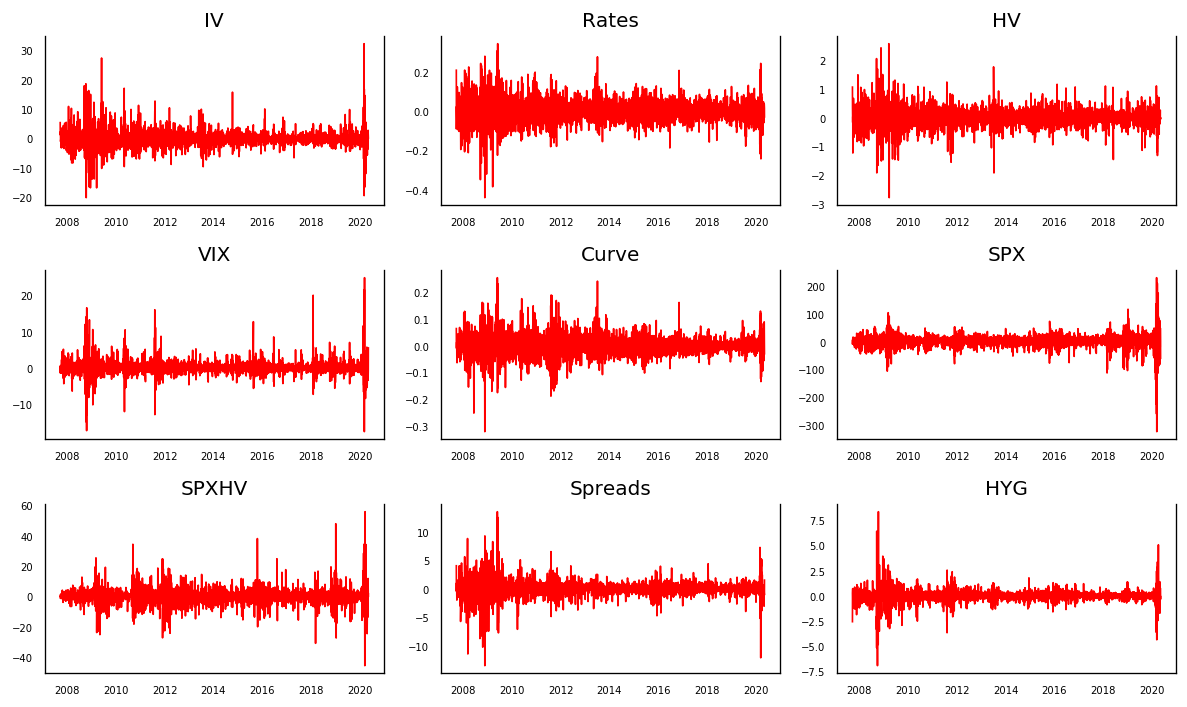

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = t[t.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(t.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

# Run a Lag Plot on the Differenced Data

In [30]:
t_scaled = pd.DataFrame(scaler.fit_transform(t), columns = t.columns)

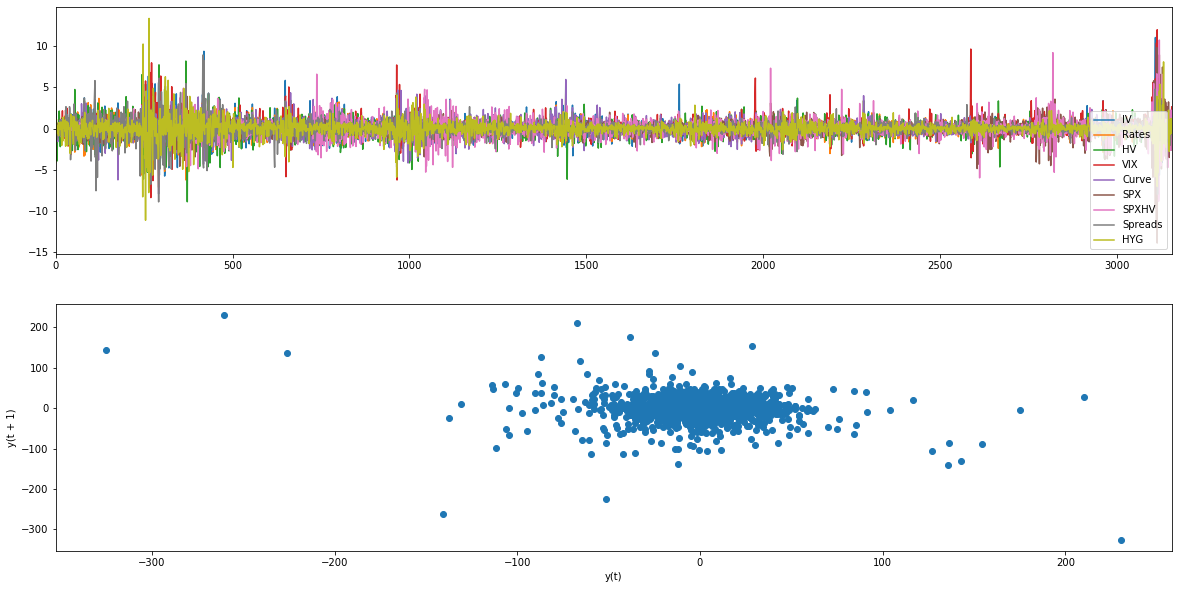

In [31]:
# Is the data Random.  Random data will not exhibit a structure in the lag plot

fig,(ax1,ax2)=plt.subplots(nrows=2, ncols=1, figsize=(20,10))
t_scaled.plot(ax=ax1) # series plot
pd.plotting.lag_plot(t) #lag plot

# Run Autocorrelation Plots on each of the Differenced Variables for All Days in the Time Series

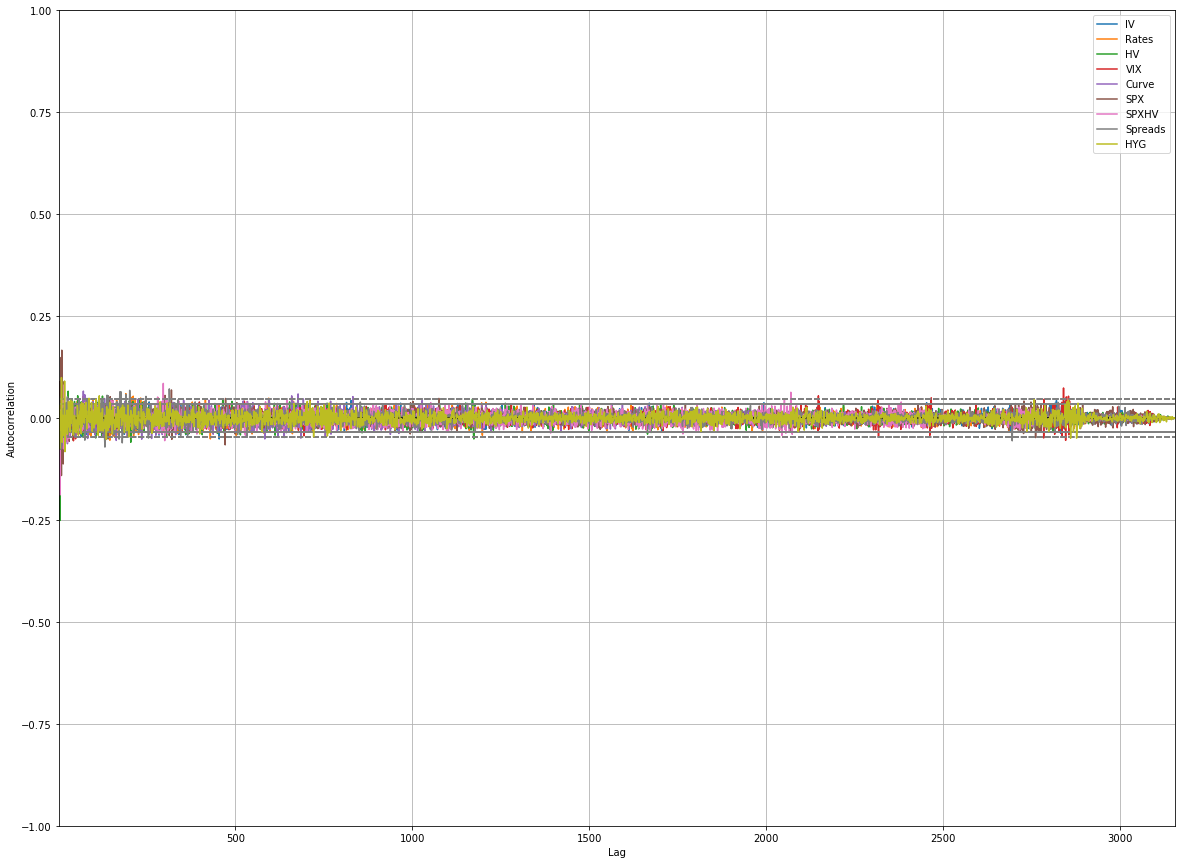

In [32]:
pd.plotting.autocorrelation_plot(t.IV, label = 'IV')
pd.plotting.autocorrelation_plot(t.Rates, label = 'Rates')
pd.plotting.autocorrelation_plot(t.HV, label = 'HV')
pd.plotting.autocorrelation_plot(t.VIX, label = 'VIX')
pd.plotting.autocorrelation_plot(t.Curve, label = 'Curve')
pd.plotting.autocorrelation_plot(t.SPX, label = 'SPX')
pd.plotting.autocorrelation_plot(t.SPXHV, label = 'SPXHV')
pd.plotting.autocorrelation_plot(t.Spreads, label = 'Spreads')
pd.plotting.autocorrelation_plot(t.HYG, label = 'HYG')
plt.rcParams["figure.figsize"] = (20,15)

# Run Autocorrelation and PACF plots for each differenced variable for 75 days

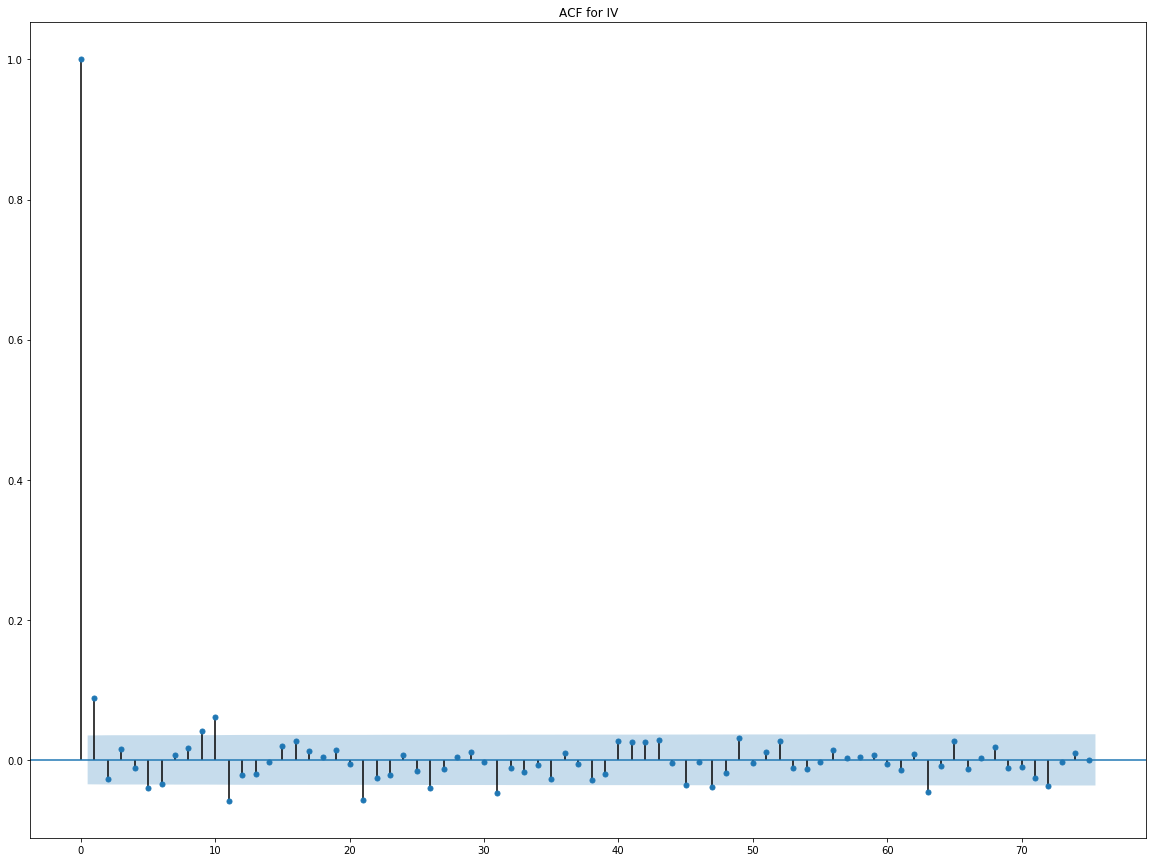

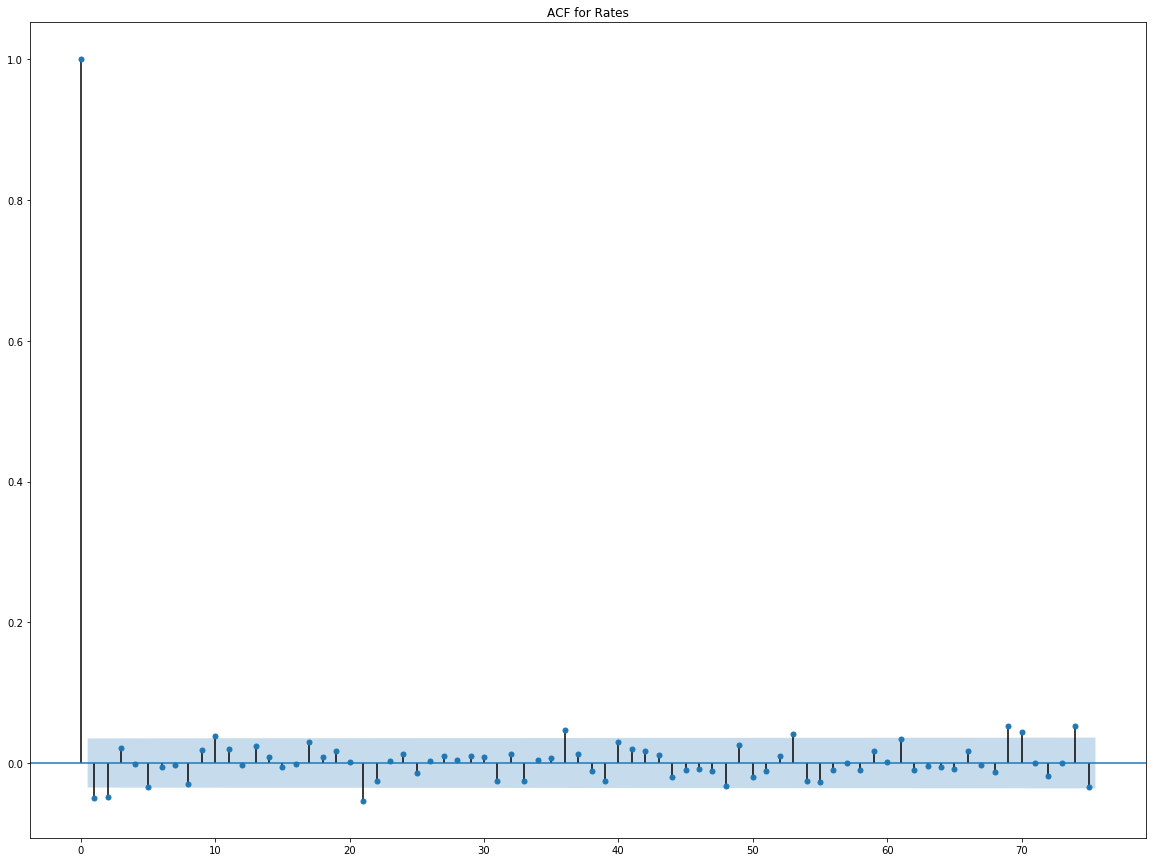

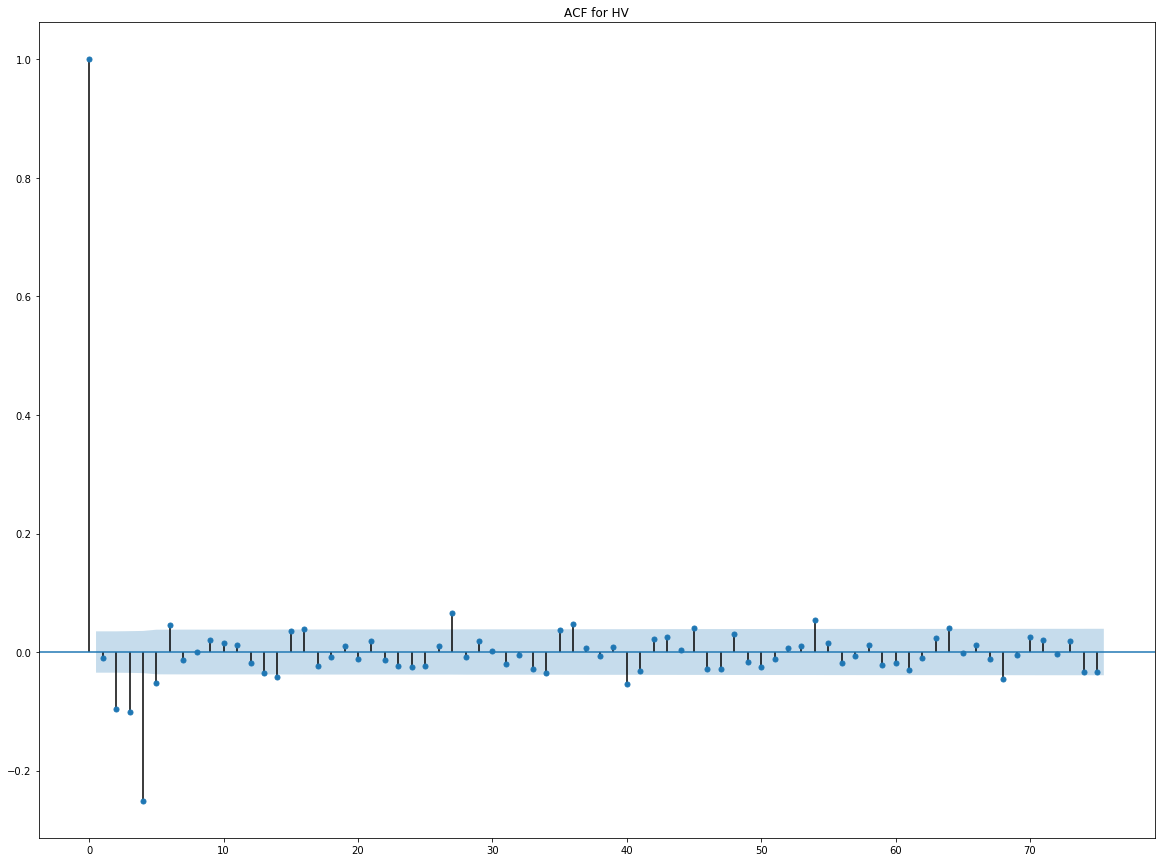

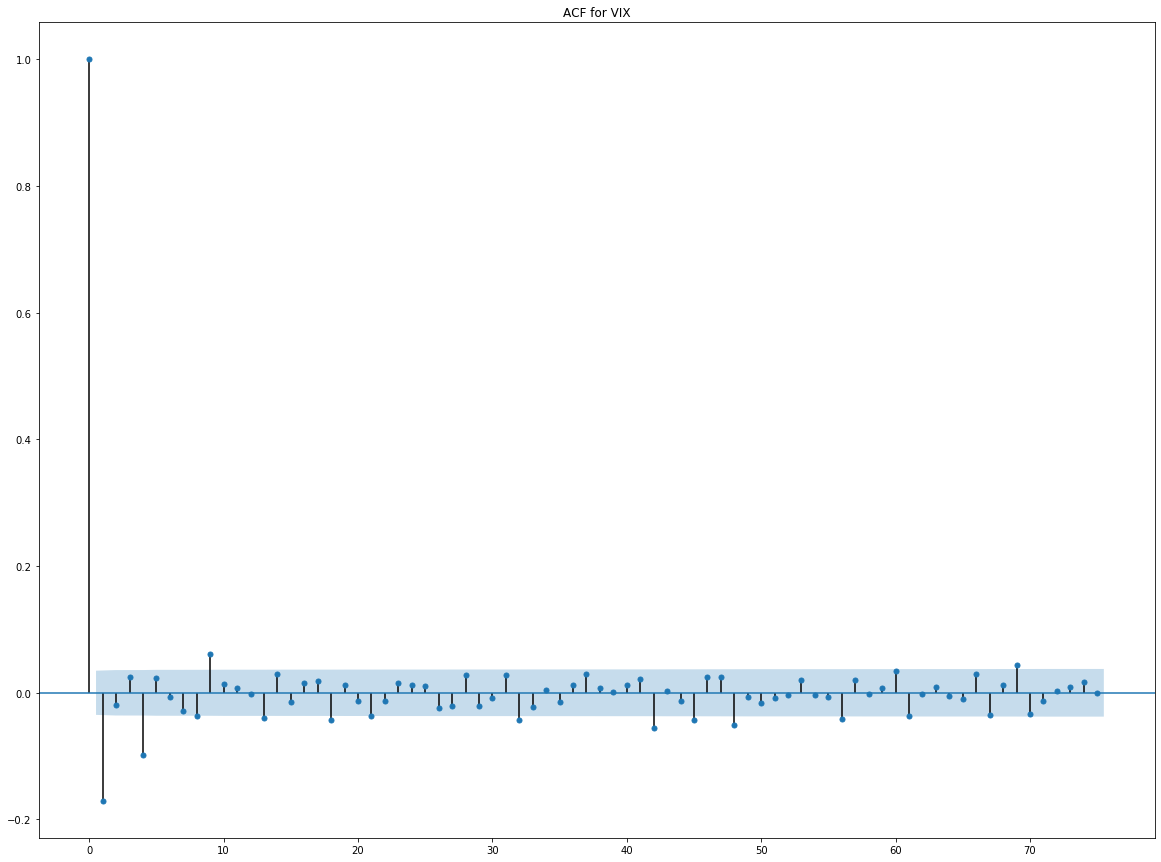

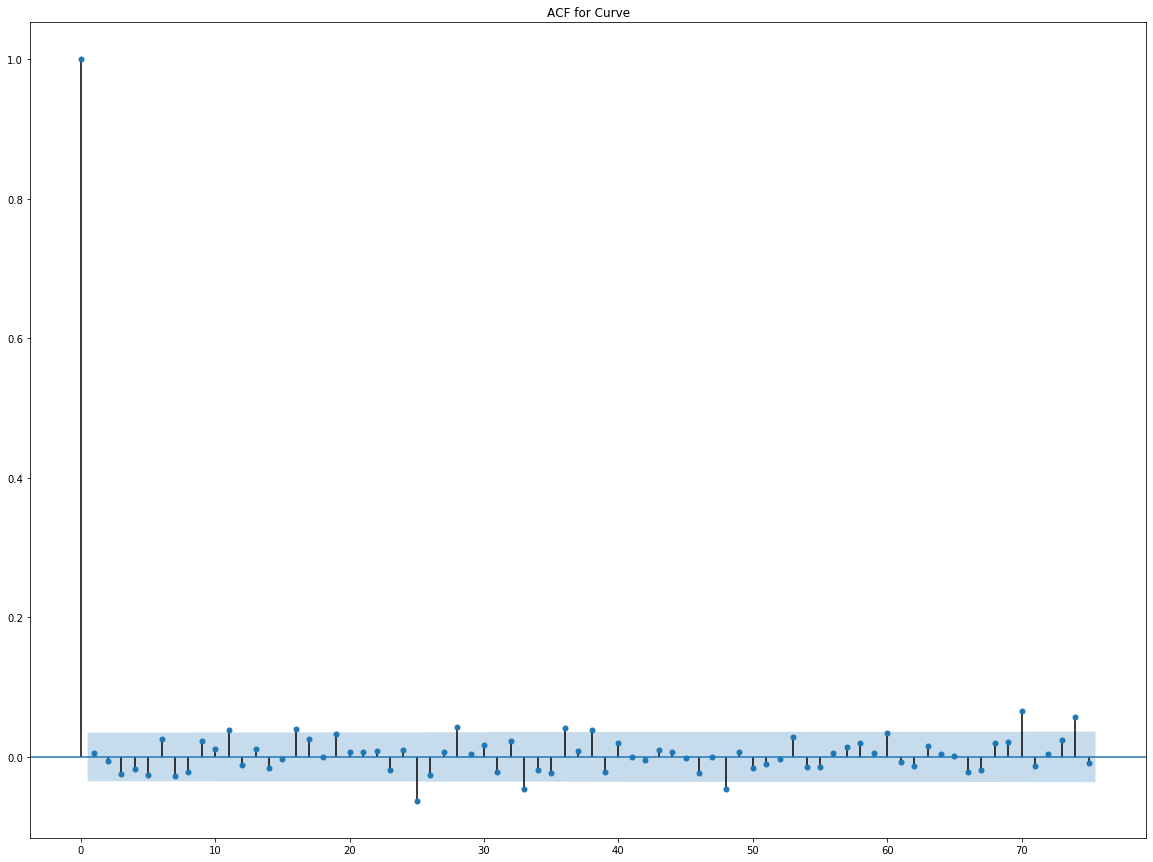

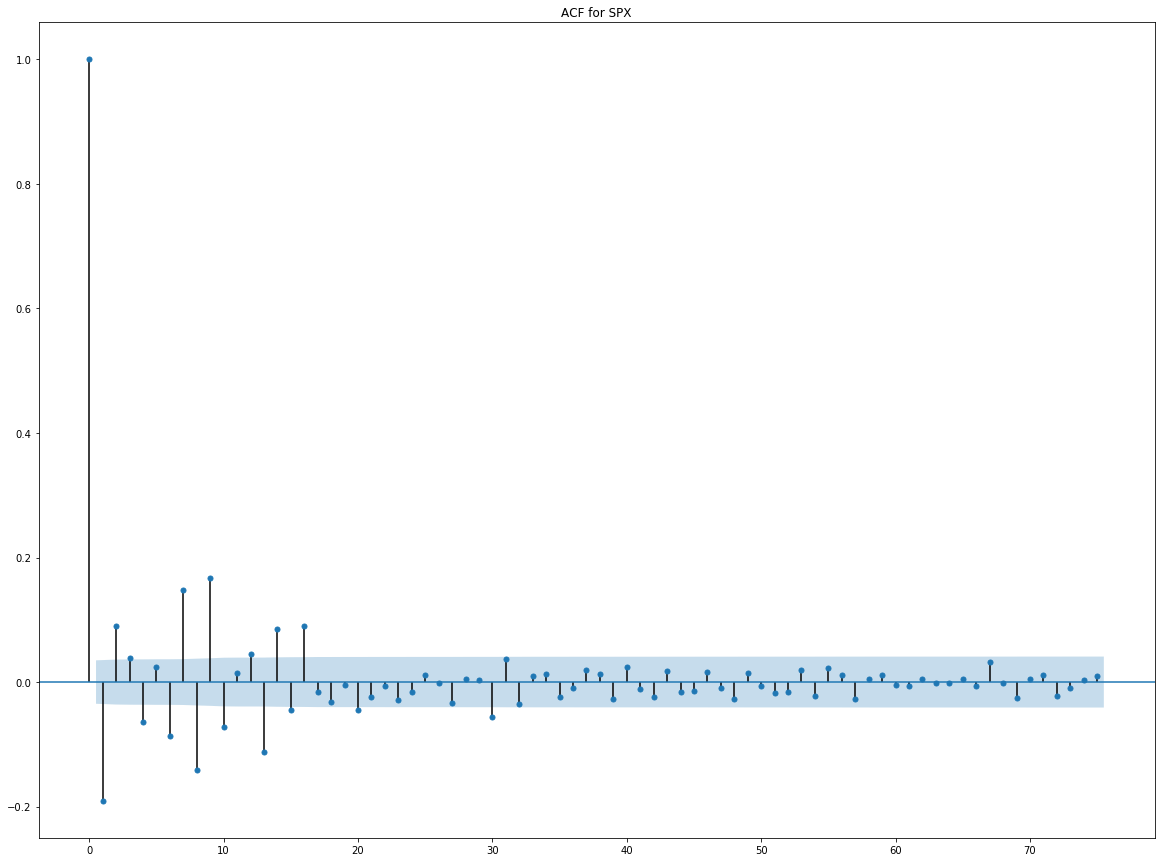

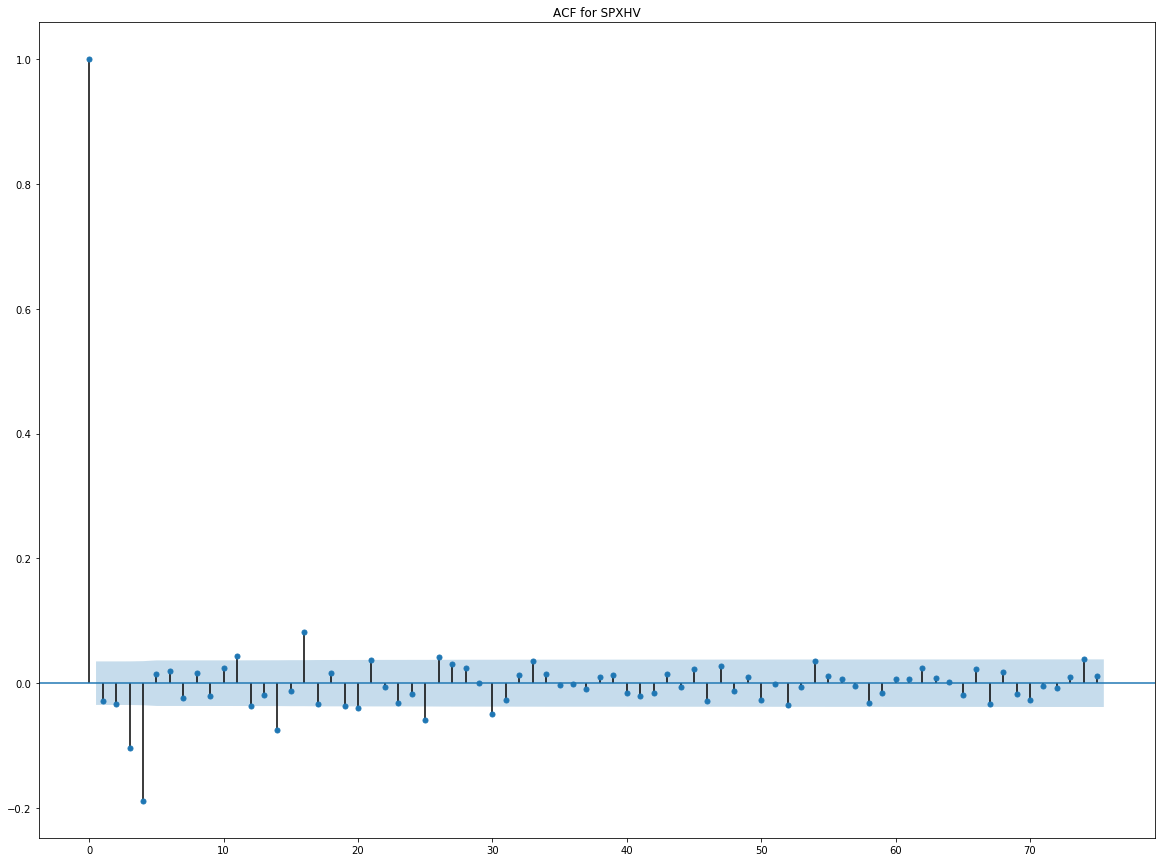

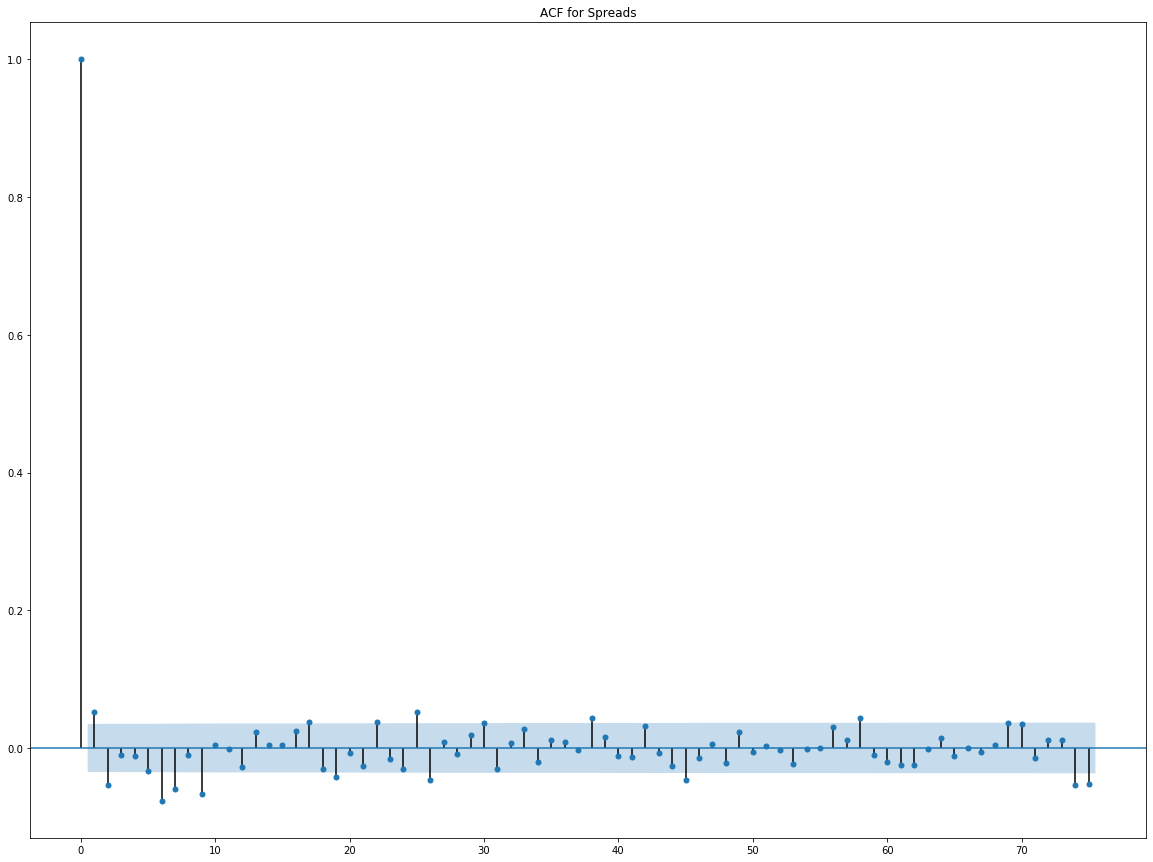

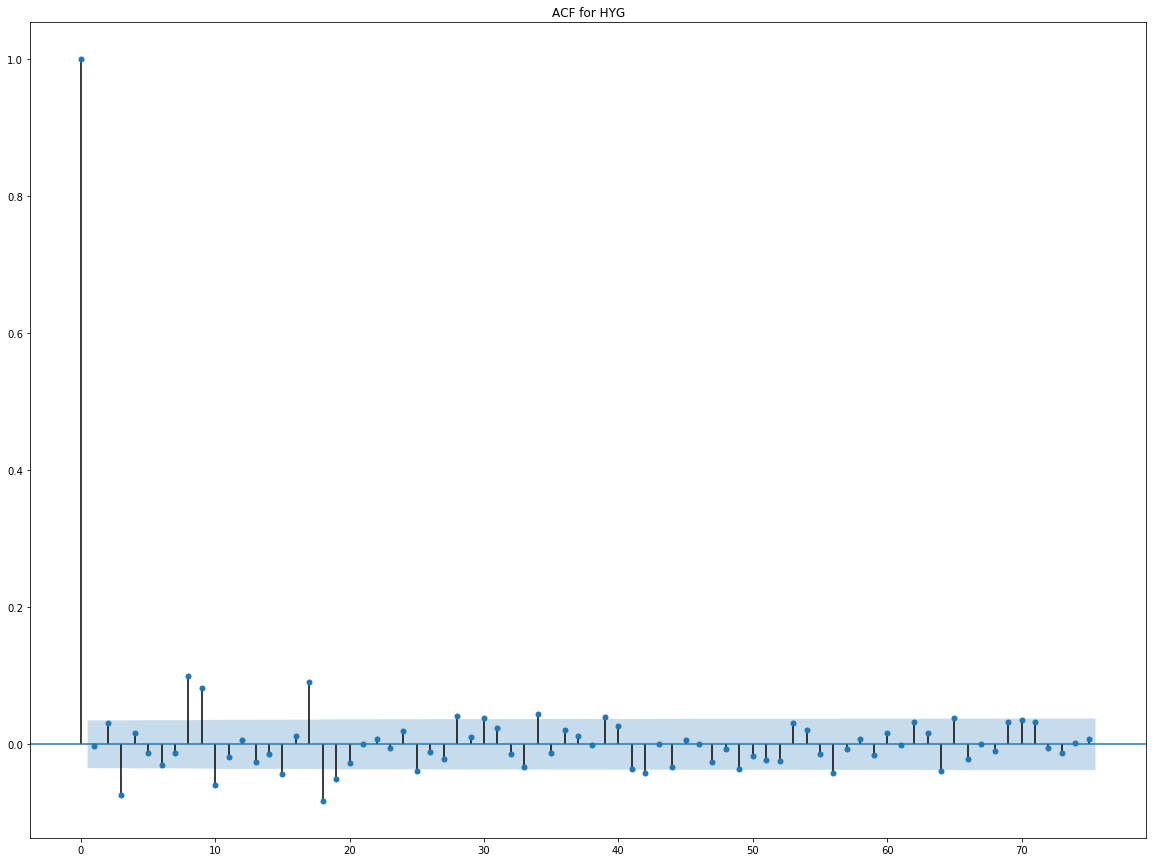

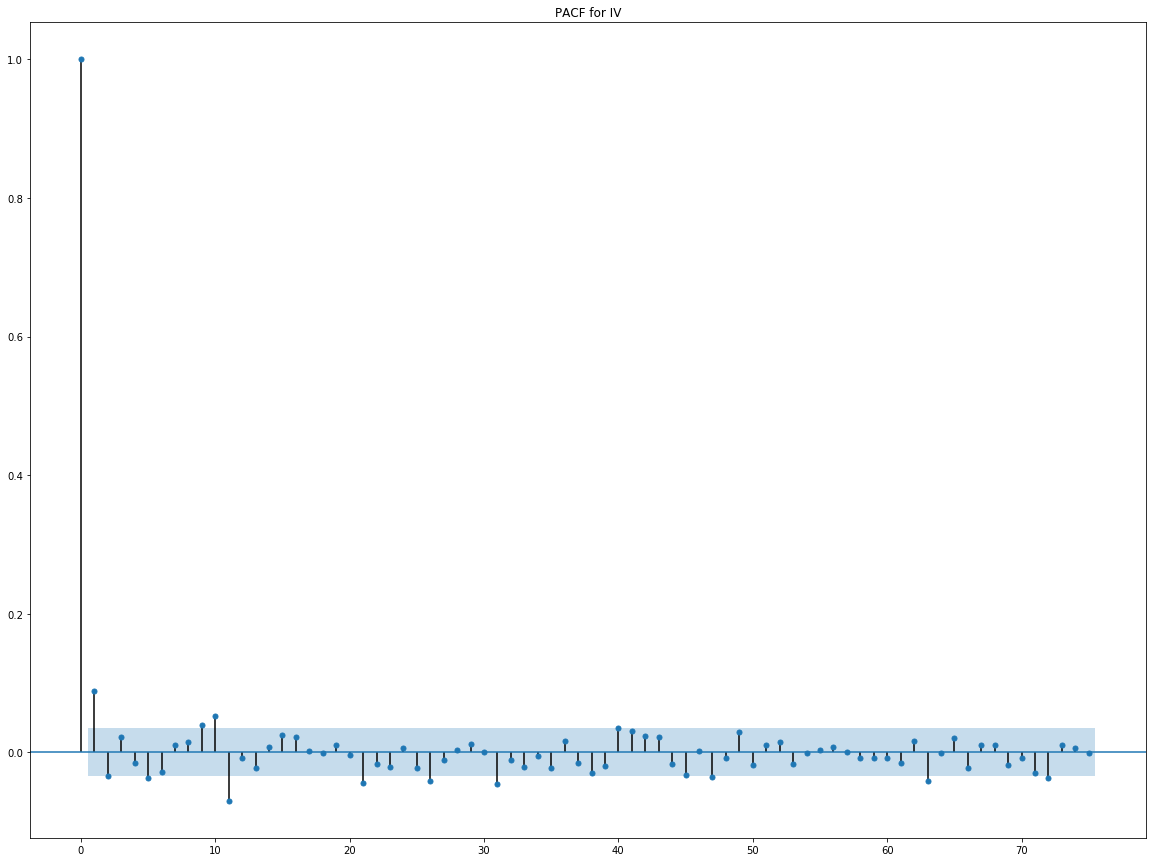

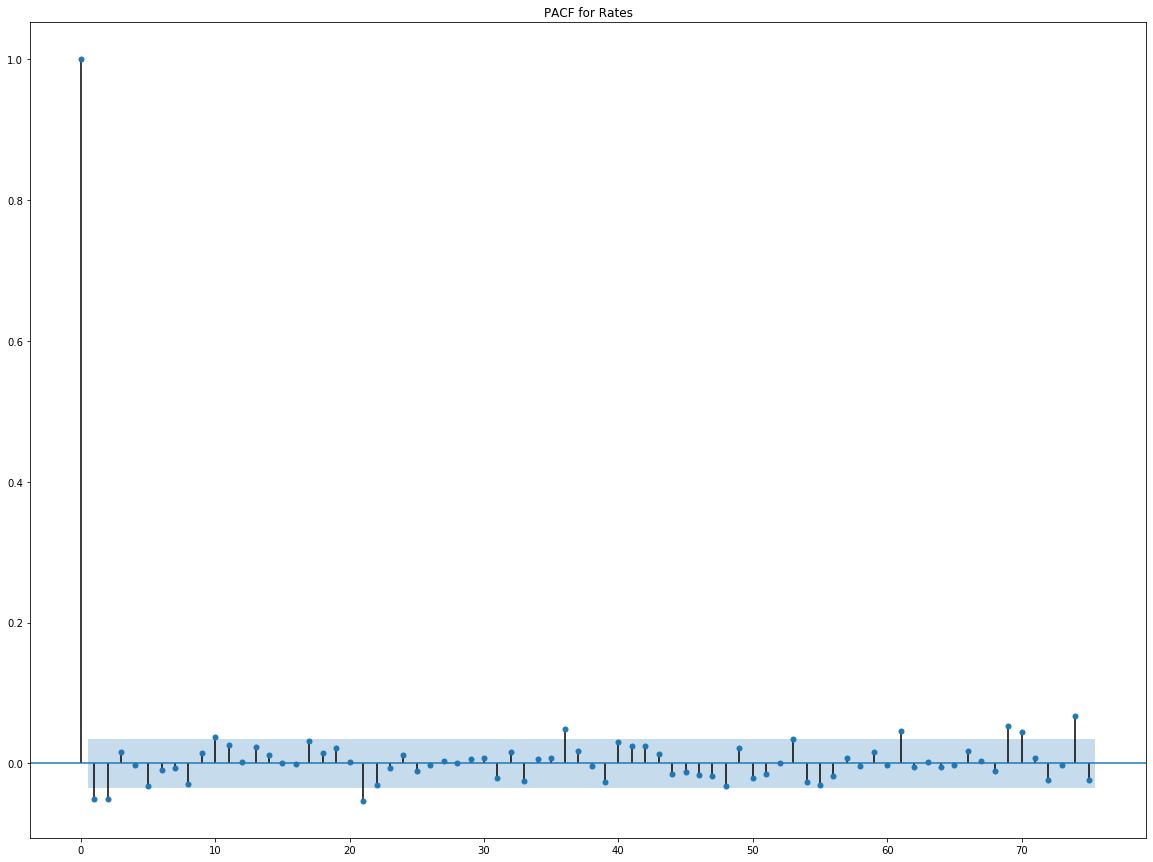

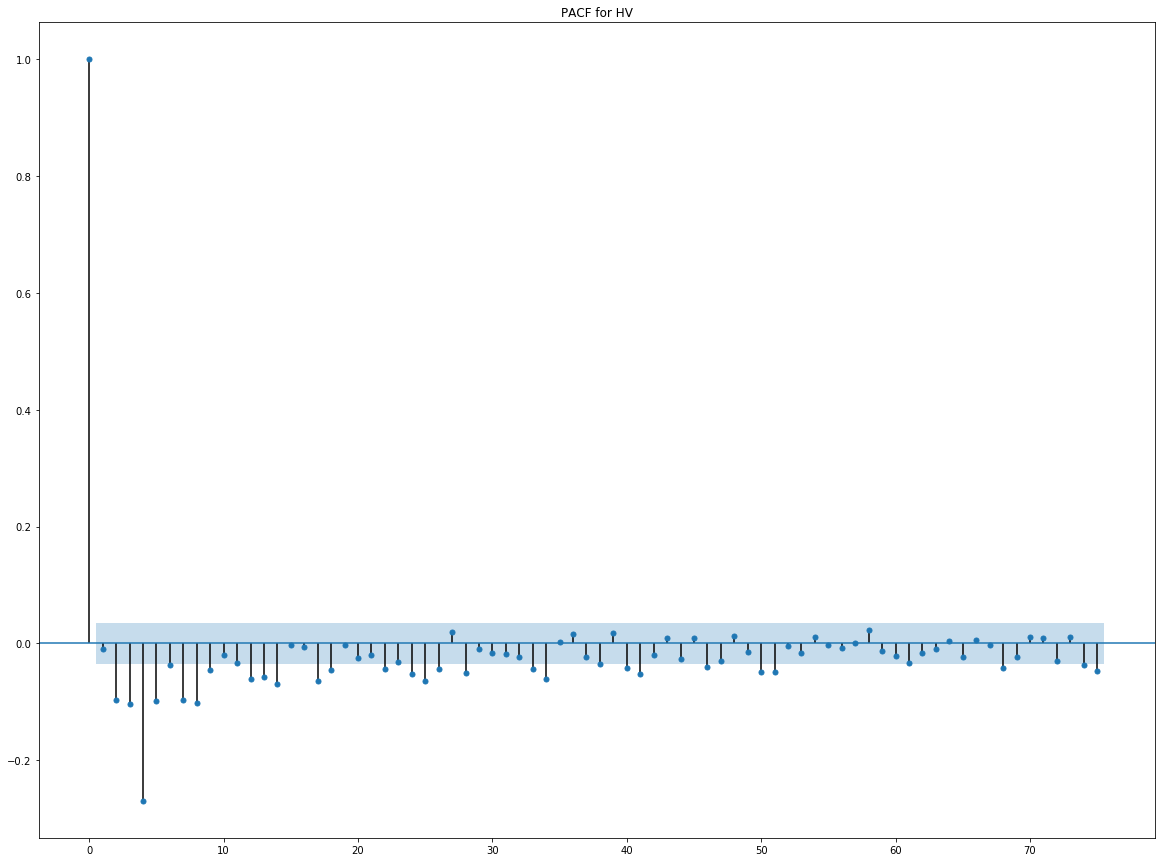

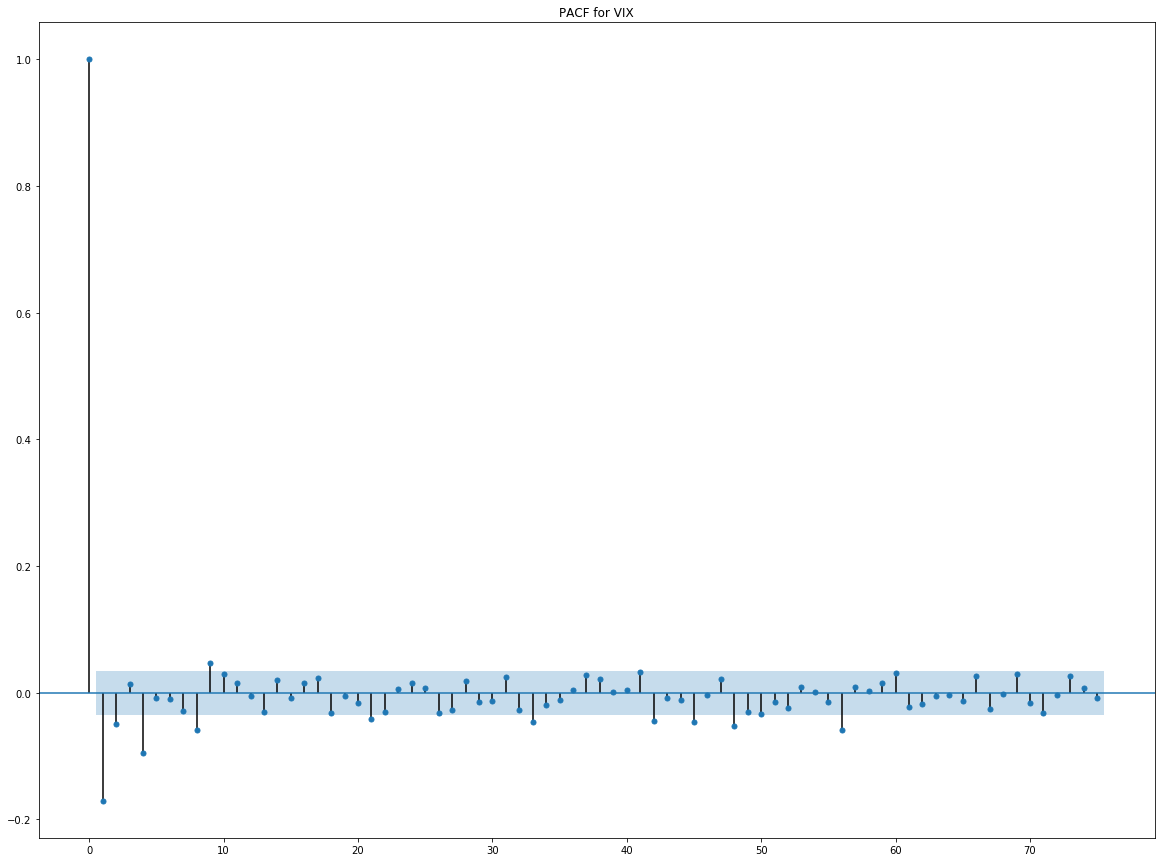

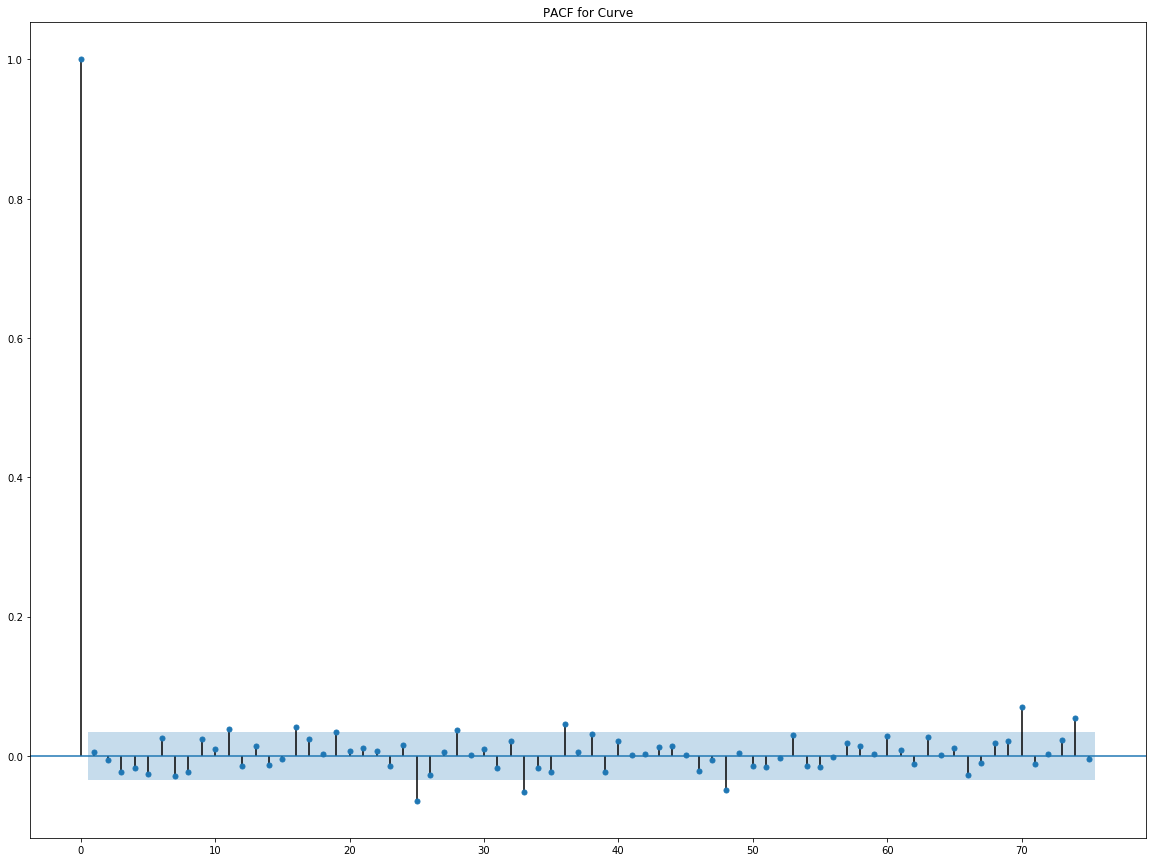

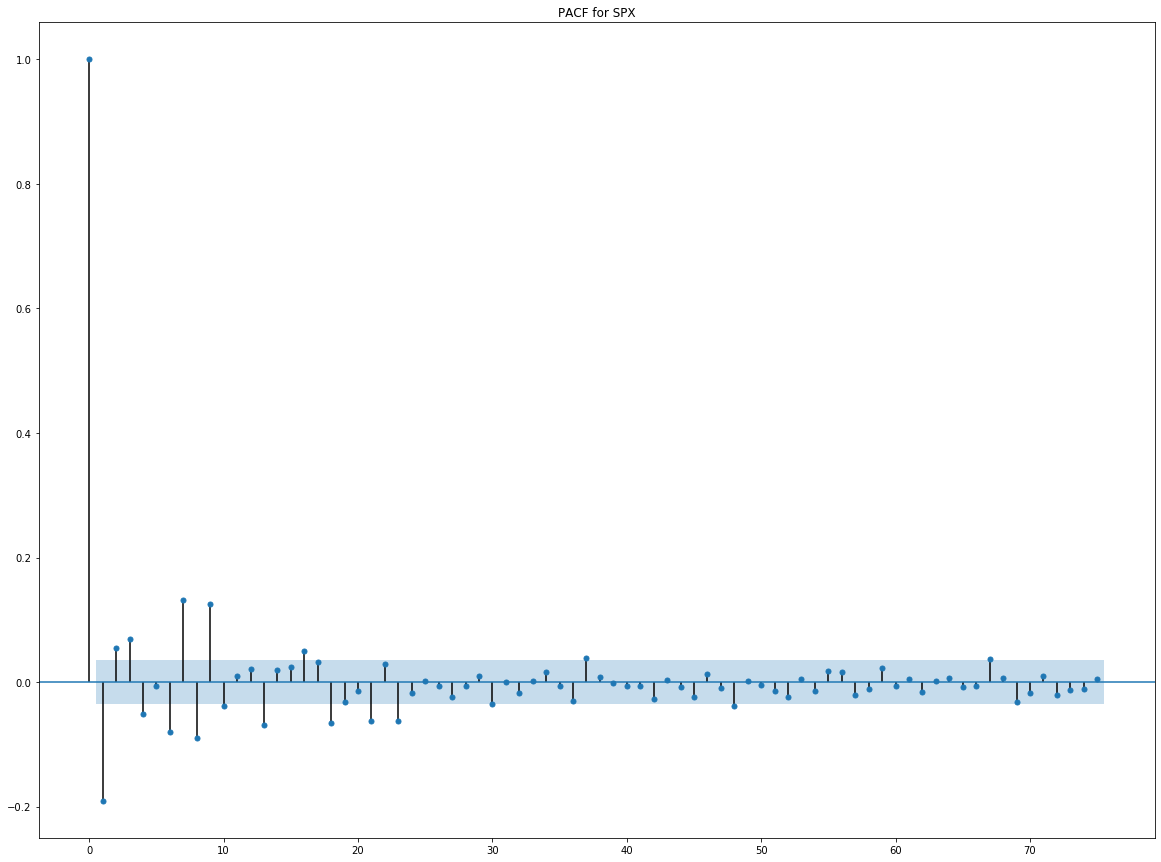

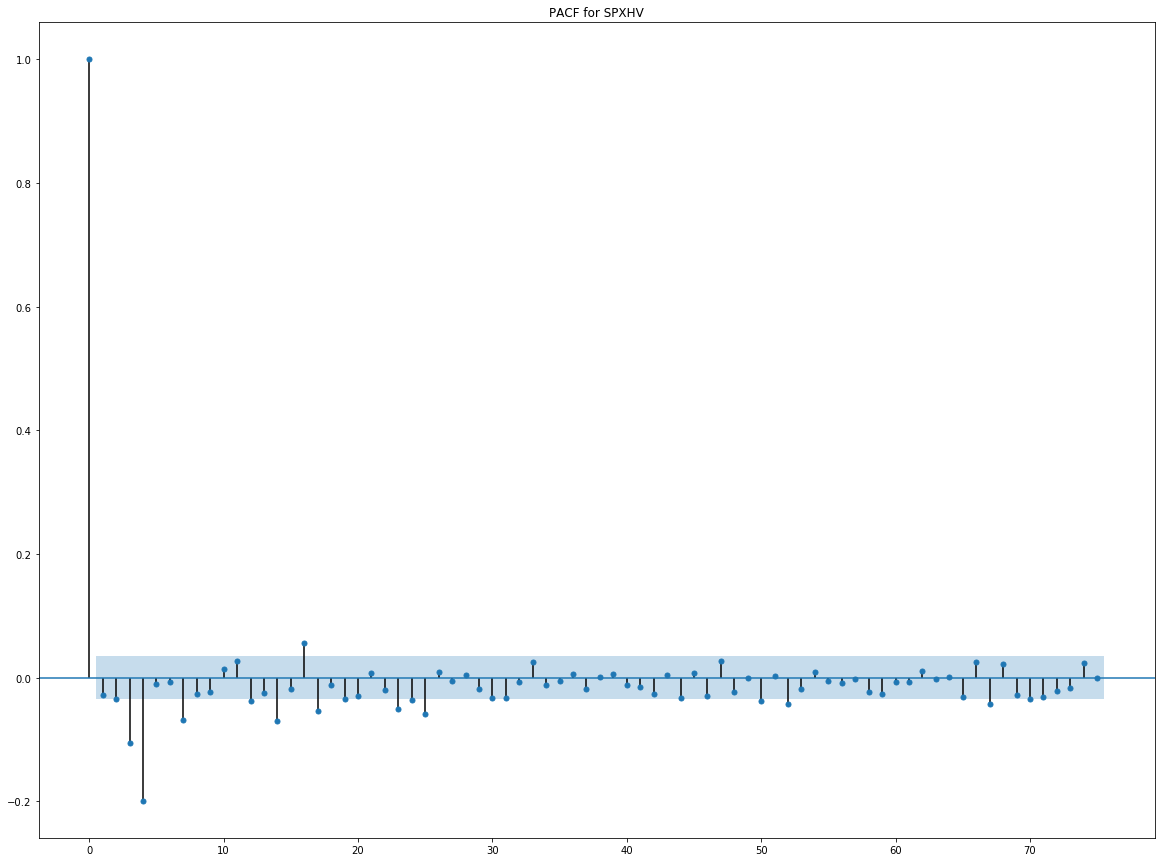

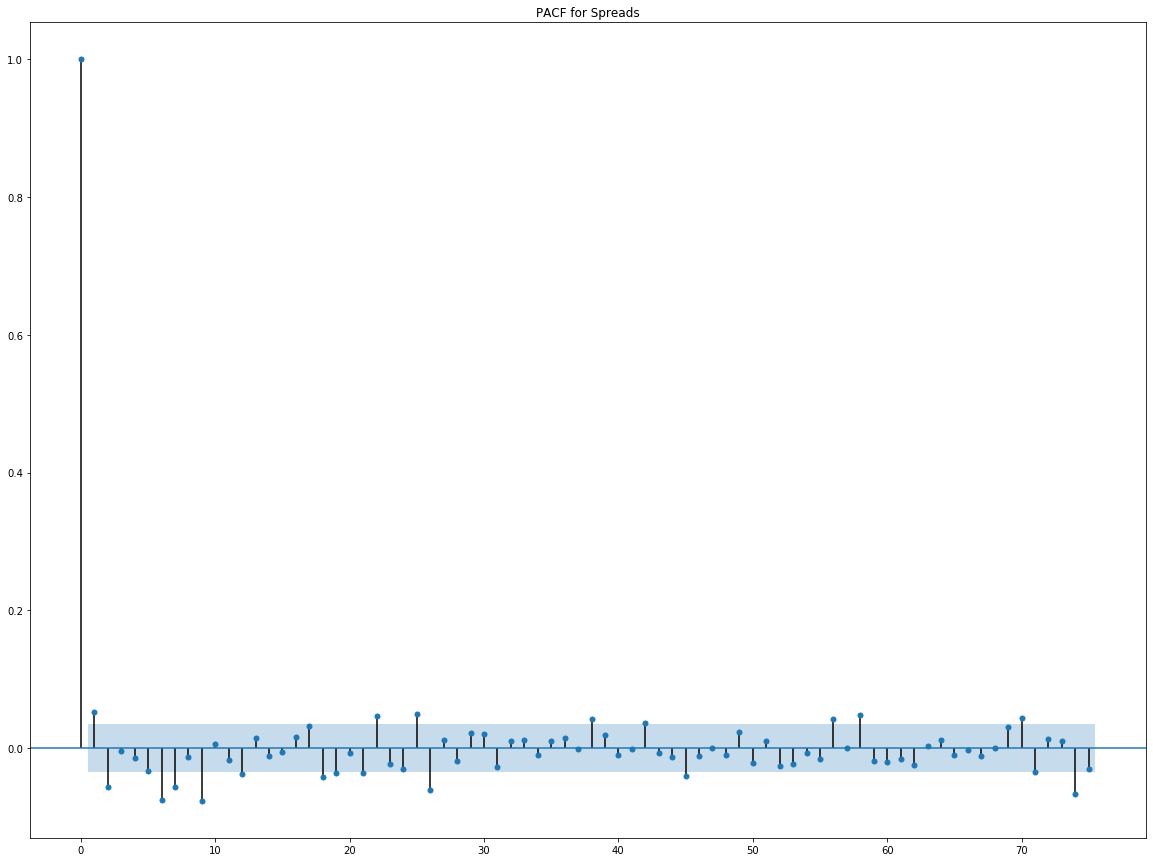

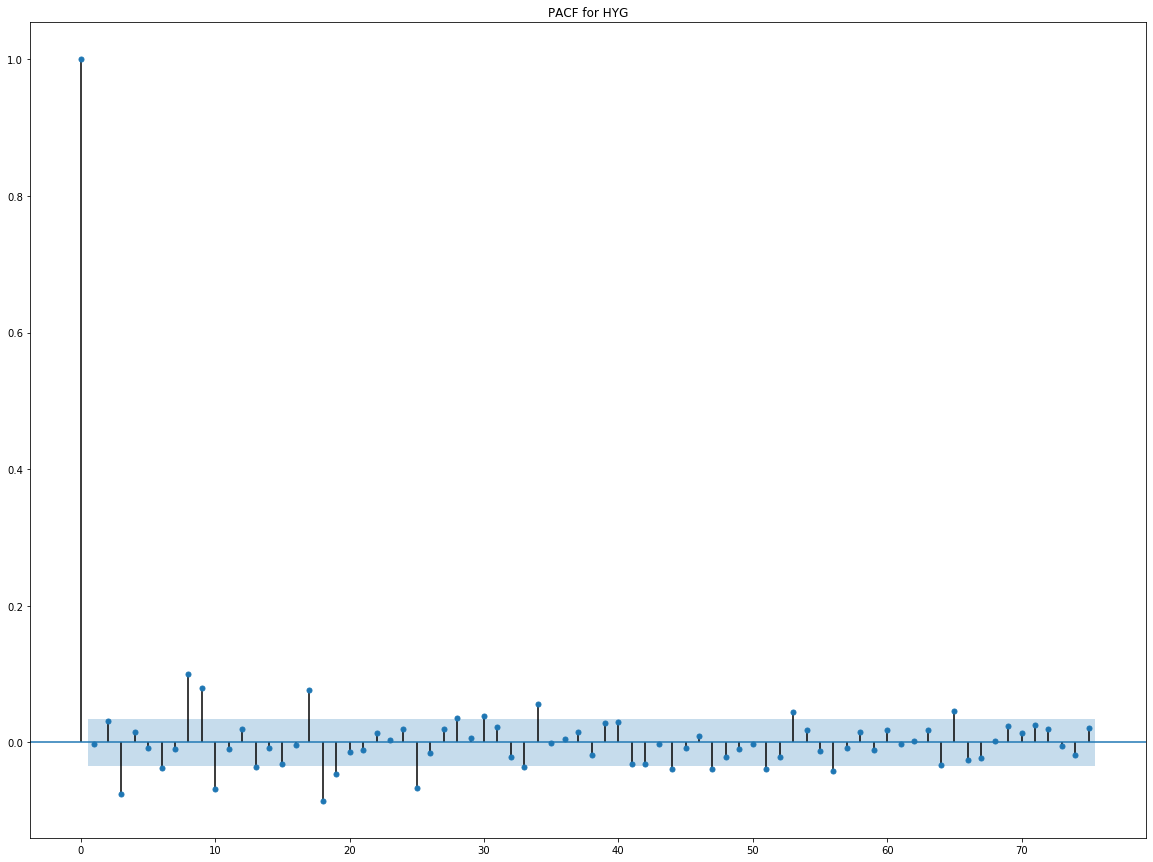

In [33]:
for i in t:
    plot_acf(t[i],lags=75)
    plt.title('ACF for %s'%i)
    
for j in t:
    plot_pacf(t[j], lags=75)
    plt.title('PACF for %s'%j)

# Run Granger Causality Tests on Every Differenced Variable

In [34]:
grangers_causation_matrix(t, variables = t.columns)

C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\pjant\Miniconda3\envs\data601

,IV_x,Rates_x,HV_x,VIX_x,Curve_x,SPX_x,SPXHV_x,Spreads_x,HYG_x
IV_y,1.0,0.0001,0.0001,0.0000,0.0136,0.3187,0.0000,0.0064,0.0000
Rates_y,0.0,1.0000,0.0003,0.0000,0.0013,0.0118,0.0928,0.0048,0.0118
HV_y,0.0,0.0006,1.0000,0.0000,0.0027,0.0412,0.0061,0.1218,0.0000
VIX_y,0.0,0.0054,0.0003,1.0000,0.0002,0.0000,0.0000,0.0000,0.0000
Curve_y,0.0,0.0064,0.0123,0.0020,1.0000,0.0171,0.0217,0.0008,0.0474
SPX_y,0.0,0.0717,0.0007,0.0000,0.0191,1.0000,0.0000,0.0021,0.0017
SPXHV_y,0.0,0.2673,0.0013,0.0003,0.4292,0.0000,1.0000,0.0185,0.0028
Spreads_y,0.0,0.0000,0.0006,0.0000,0.0001,0.0000,0.0013,0.9993,0.0000
HYG_y,0.0,0.1931,0.0002,0.0000,0.0007,0.0000,0.0012,0.0000,1.0000


In [35]:
from statsmodels.tsa.stattools import grangercausalitytests
print(grangercausalitytests(t[['IV','Rates']], maxlag=30, addconst=True, verbose=True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0007  , p=0.9795  , df_denom=3152, df_num=1
ssr based chi2 test:   chi2=0.0007  , p=0.9795  , df=1
likelihood ratio test: chi2=0.0007  , p=0.9795  , df=1
parameter F test:         F=0.0007  , p=0.9795  , df_denom=3152, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6943  , p=0.1839  , df_denom=3149, df_num=2
ssr based chi2 test:   chi2=3.3940  , p=0.1832  , df=2
likelihood ratio test: chi2=3.3922  , p=0.1834  , df=2
parameter F test:         F=1.6943  , p=0.1839  , df_denom=3149, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6695  , p=0.1714  , df_denom=3146, df_num=3
ssr based chi2 test:   chi2=5.0198  , p=0.1704  , df=3
likelihood ratio test: chi2=5.0158  , p=0.1706  , df=3
parameter F test:         F=1.6695  , p=0.1714  , df_denom=3146, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8858  , p=0.

ssr based F test:         F=2.5275  , p=0.0000  , df_denom=3068, df_num=29
ssr based chi2 test:   chi2=74.7085 , p=0.0000  , df=29
likelihood ratio test: chi2=73.8300 , p=0.0000  , df=29
parameter F test:         F=2.5275  , p=0.0000  , df_denom=3068, df_num=29

Granger Causality
number of lags (no zero) 30
ssr based F test:         F=2.4996  , p=0.0000  , df_denom=3065, df_num=30
ssr based chi2 test:   chi2=76.4794 , p=0.0000  , df=30
likelihood ratio test: chi2=75.5588 , p=0.0000  , df=30
parameter F test:         F=2.4996  , p=0.0000  , df_denom=3065, df_num=30
{1: ({'ssr_ftest': (0.0006574825558797011, 0.9795449695799567, 3152.0, 1), 'ssr_chi2test': (0.0006581083324240028, 0.9795336157853335, 1), 'lrtest': (0.0006581082634511404, 0.9795336168575851, 1), 'params_ftest': (0.0006574825555492605, 0.9795449695799567, 3152.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000025B3A52CC18>, <statsmodels.regression.linear_model.RegressionResultsWrapper o

# Run Cointegration Tests for Each of the Differenced Variables

In [36]:
cointegration_test(t)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
IV     ::  5918.41   > 179.5199  =>   True
Rates  ::  4900.62   > 143.6691  =>   True
HV     ::  3906.74   > 111.7797  =>   True
VIX    ::  3195.53   > 83.9383   =>   True
Curve  ::  2540.87   > 60.0627   =>   True
SPX    ::  1946.45   > 40.1749   =>   True
SPXHV  ::  1378.97   > 24.2761   =>   True
Spreads ::  892.78    > 12.3212   =>   True
HYG    ::  425.57    > 4.1296    =>   True


# Run Dickey-Fuller Tests on the Differenced Data to Check for Stationarity

In [37]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in t.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "IV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.887
 No. Lags Chosen       = 10
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Rates" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -42.8144
 No. Lags Chosen       = 1
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 

# Test for best Lags to Use

In [38]:
model = VAR(t)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag Order = 1
AIC :  -2.8663681073341434
BIC :  -2.6935925321367495
FPE :  0.05690523626822858
HQIC:  -2.804380244952365 

Lag Order = 2
AIC :  -2.9462613441880894
BIC :  -2.617900856792265
FPE :  0.05253582125240547
HQIC:  -2.8284513301862906 

Lag Order = 3
AIC :  -3.016013587155531
BIC :  -2.531985793243271
FPE :  0.04899635433421373
HQIC:  -2.842350058195573 

Lag Order = 4
AIC :  -3.198766238681214
BIC :  -2.558988673270174
FPE :  0.04081292196740031
HQIC:  -2.969217803738786 

Lag Order = 5
AIC :  -3.22685030681689
BIC :  -2.431240434177248
FPE :  0.03968303005474061
HQIC:  -2.941385547148325 

Lag Order = 6
AIC :  -3.259697470466909
BIC :  -2.3081726840381025
FPE :  0.03840124006202554
HQIC:  -2.918284939575942 

Lag Order = 7
AIC :  -3.3220177764255894
BIC :  -2.2144953987329283
FPE :  0.03608177481860425
HQIC:  -2.924626000030072 

Lag Order = 8
AIC :  -3.377018637026957
BIC :  -2.1134159195981126
FPE :  0.03415166996680826
HQIC:  -2.9236161130255196 

Lag Order = 9
AIC :  -3.

In [39]:
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,-2.675,-2.658,0.06888,-2.669
1,-2.854,-2.681*,0.05760,-2.792
2,-2.936,-2.606,0.05306,-2.818
3,-3.008,-2.521,0.04941,-2.833
4,-3.192,-2.549,0.04109,-2.961*
5,-3.218,-2.419,0.04004,-2.931
6,-3.250,-2.295,0.03876,-2.908
7,-3.315,-2.204,0.03634,-2.916
8,-3.372,-2.105,0.03431,-2.918
9,-3.425,-2.001,0.03256,-2.914


# Fit the Model

In [40]:
model_fitted = model.fit(20)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 24, May, 2020
Time:                     14:02:35
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                  -0.412258
Nobs:                     3136.00    HQIC:                  -2.42731
Log likelihood:          -32844.4    FPE:                  0.0286057
AIC:                     -3.55530    Det(Omega_mle):       0.0172635
--------------------------------------------------------------------
Results for equation IV
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.034931         0.051241           -0.682           0.495
L1.IV               0.035535         0.020224            1.757           0.079
L1.Rates            3.391403         1.283710            2.642         

# Run Durbin Watson Stats on Fitted Model

In [41]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(t.columns, out):
    print((col), ':', round(val, 2))

IV : 2.01
Rates : 2.0
HV : 2.0
VIX : 2.0
Curve : 2.0
SPX : 1.99
SPXHV : 2.0
Spreads : 2.0
HYG : 2.0


# Run the Forecasts

In [42]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = t.values[-lag_order:]
forecast_input

20


array([[ 1.02430000e+00, -1.23700000e-01,  7.00000000e-01,
         3.08000000e+00, -9.49000000e-02, -6.27000000e+01,
         6.03110695e+00, -3.00000000e-01, -7.60000000e-01],
       [ 1.71820000e+00,  2.80000000e-03,  8.00000000e-03,
        -7.30000000e-01, -1.24000000e-02,  1.61900000e+01,
        -1.62472967e+00,  6.90000000e-01, -8.00000000e-02],
       [ 3.90000000e-03,  1.01000000e-02, -1.04000000e-01,
        -1.96000000e+00,  1.92000000e-02,  7.50100000e+01,
         2.27340312e+00, -4.40000000e-01,  4.10000000e-01],
       [-3.40640000e+00, -4.05000000e-02, -1.00000000e-02,
         5.68000000e+00, -4.60000000e-02, -5.14000000e+01,
        -2.25739745e+00, -5.00000000e-01, -1.22000000e+00],
       [ 2.15500000e+00, -3.45000000e-02, -5.77146423e-01,
         1.58000000e+00, -2.25000000e-02, -8.66000000e+01,
         4.67175547e+00,  3.80000000e-01, -1.46000000e+00],
       [-2.15000000e-01,  2.52000000e-02,  1.10588078e-01,
        -3.43000000e+00,  3.08000000e-02,  6.275000

# Test the Model

In [43]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = t.values[-lag_order:]
forecast_input

20


array([[ 1.02430000e+00, -1.23700000e-01,  7.00000000e-01,
         3.08000000e+00, -9.49000000e-02, -6.27000000e+01,
         6.03110695e+00, -3.00000000e-01, -7.60000000e-01],
       [ 1.71820000e+00,  2.80000000e-03,  8.00000000e-03,
        -7.30000000e-01, -1.24000000e-02,  1.61900000e+01,
        -1.62472967e+00,  6.90000000e-01, -8.00000000e-02],
       [ 3.90000000e-03,  1.01000000e-02, -1.04000000e-01,
        -1.96000000e+00,  1.92000000e-02,  7.50100000e+01,
         2.27340312e+00, -4.40000000e-01,  4.10000000e-01],
       [-3.40640000e+00, -4.05000000e-02, -1.00000000e-02,
         5.68000000e+00, -4.60000000e-02, -5.14000000e+01,
        -2.25739745e+00, -5.00000000e-01, -1.22000000e+00],
       [ 2.15500000e+00, -3.45000000e-02, -5.77146423e-01,
         1.58000000e+00, -2.25000000e-02, -8.66000000e+01,
         4.67175547e+00,  3.80000000e-01, -1.46000000e+00],
       [-2.15000000e-01,  2.52000000e-02,  1.10588078e-01,
        -3.43000000e+00,  3.08000000e-02,  6.275000

In [44]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_test.index[-nobs:], columns=t.columns + '_1d')
df_forecast

,IV_1d,Rates_1d,HV_1d,VIX_1d,Curve_1d,SPX_1d,SPXHV_1d,Spreads_1d,HYG_1d
Date,,,,,,,,,
2020-05-13,-0.061319,-0.019215,0.001154,-0.237186,0.005268,-6.111643,0.522014,-0.242736,0.261918
2020-05-14,0.403448,-0.010360,0.142829,-0.139395,-0.002799,-11.559043,3.018142,1.081810,0.187046
2020-05-15,-0.661584,0.001552,0.275773,-0.848097,-0.000956,-5.111297,-2.085938,0.072345,0.565160
2020-05-18,-0.463443,0.005318,0.058408,-1.347068,0.001644,12.086696,-0.287558,-0.163635,0.329834
2020-05-19,-0.078163,-0.037090,-0.008656,0.650884,-0.028862,-7.787419,1.327544,-0.479541,-0.248971


In [45]:
forecast_input.shape, nobs, fc.shape

((20, 9), 5, (5, 9))

In [46]:
df_train.head()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
Date,,,,,,,,,
2007-09-19,89.70,5.1495,0.746779,20.03,0.5445,1444.61,8.416627,60.73,106.09
2007-09-20,95.05,5.3570,1.801746,20.45,0.6085,1448.39,7.389371,64.75,103.49
2007-09-21,96.25,5.2655,2.160149,19.00,0.5990,1438.87,6.817902,64.30,103.75
2007-09-24,98.50,5.2885,1.990170,19.37,0.5900,1447.80,7.175853,65.31,104.45
2007-09-25,99.50,5.2870,2.023251,18.60,0.5995,1452.85,6.948365,65.80,104.70


In [47]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
#        if second_diff:
#            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [48]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)       
df_results.loc[:, ['IV_forecast', 'Rates_forecast', 'HV_forecast', 'VIX_forecast', 'Curve_forecast',
                   'SPX_forecast', 'SPXHV_forecast', 'CDXHY_forecast','Spreads_forecast','HYG_forecast']]

C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,IV_forecast,Rates_forecast,HV_forecast,VIX_forecast,Curve_forecast,SPX_forecast,SPXHV_forecast,CDXHY_forecast,Spreads_forecast,HYG_forecast
Date,,,,,,,,,,
2020-05-13,67.429381,0.609085,0.523628,32.802814,0.371568,2864.008357,26.524938,NaN,-3.992736,79.551918
2020-05-14,67.832829,0.598725,0.666457,32.663418,0.368769,2852.449315,29.543080,NaN,-2.910926,79.738964
2020-05-15,67.171244,0.600277,0.942230,31.815322,0.367813,2847.338018,27.457141,NaN,-2.838581,80.304123
2020-05-18,66.707801,0.605595,1.000638,30.468254,0.369457,2859.424714,27.169584,NaN,-3.002216,80.633957
2020-05-19,66.629638,0.568505,0.991982,31.119138,0.340595,2851.637295,28.497128,NaN,-3.481756,80.384986


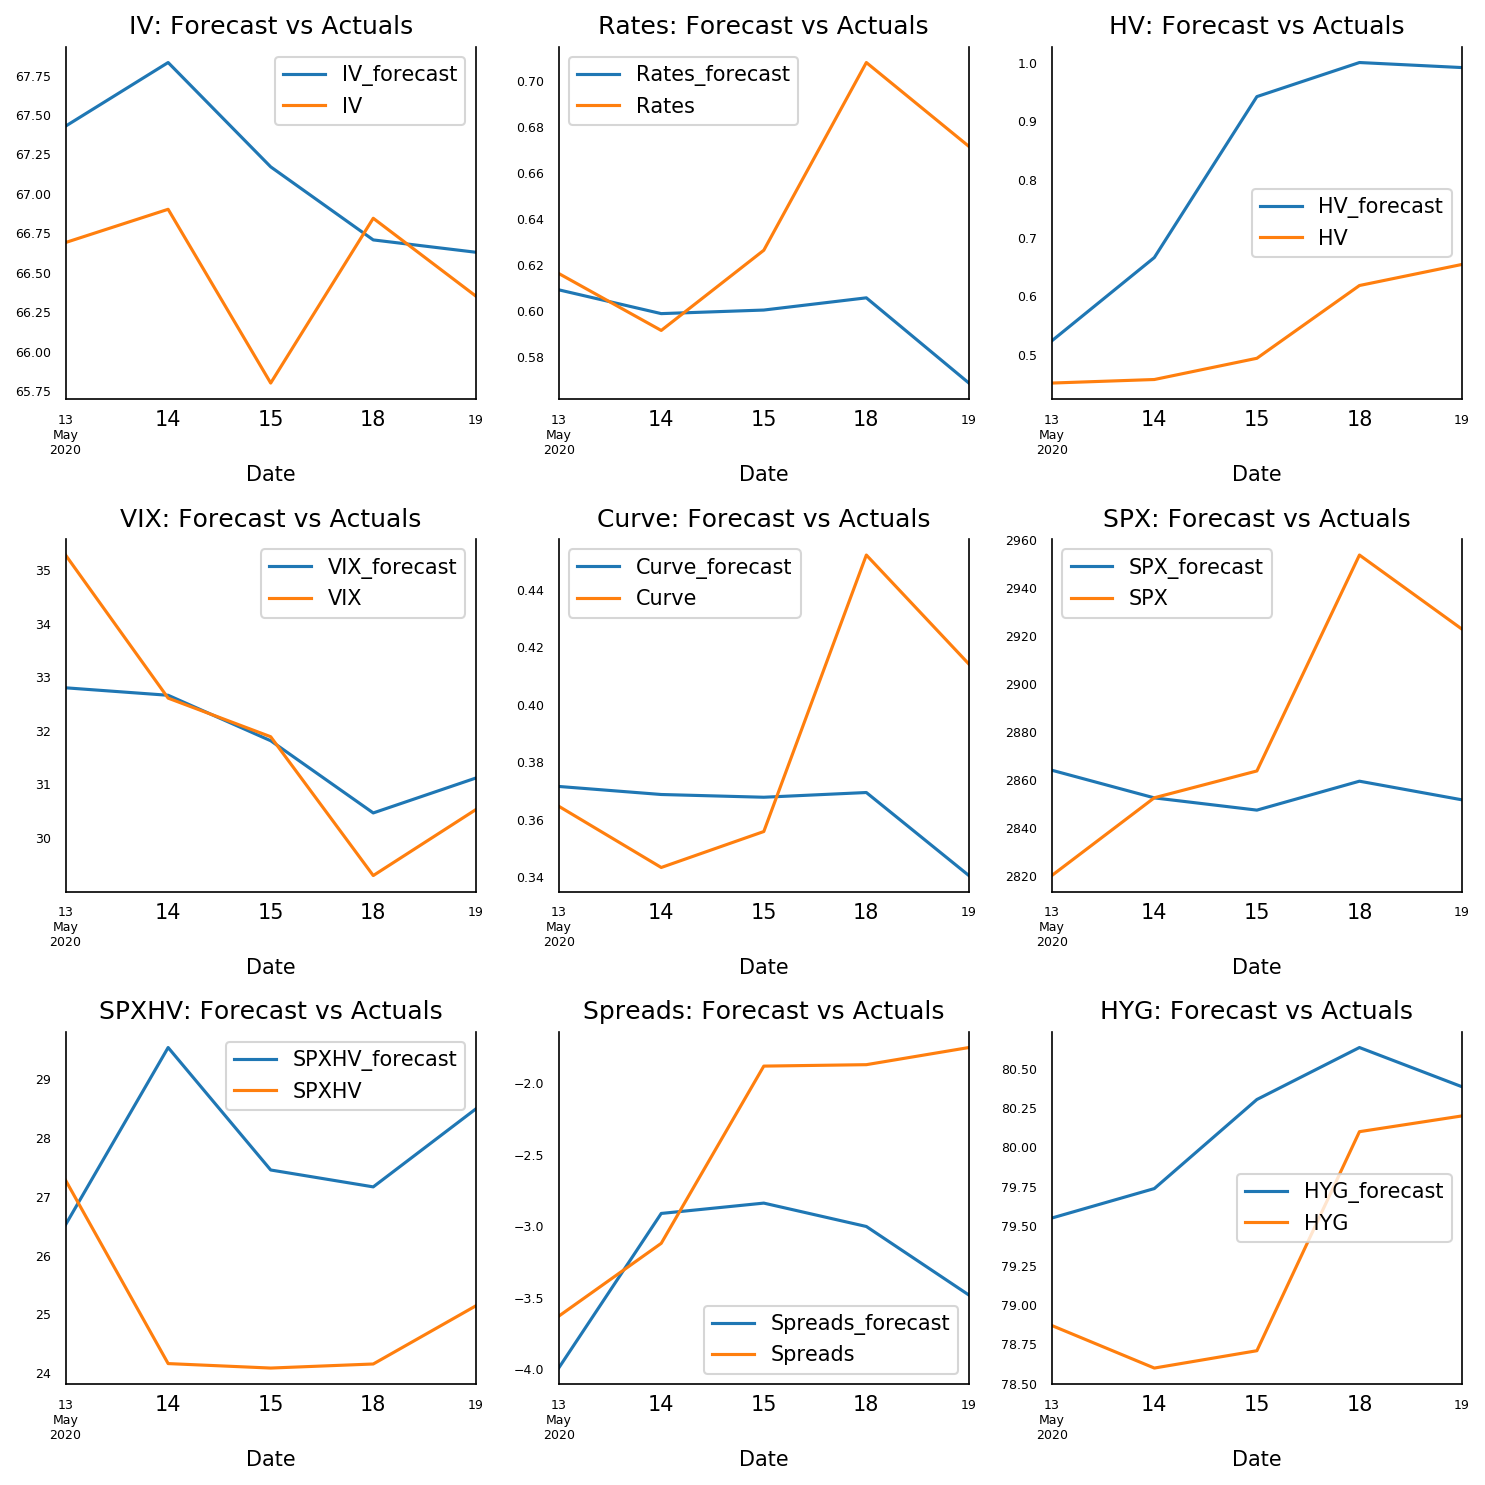

In [49]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/3), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Run the Model Accuracy Statistics

In [50]:
# mape is mean absolute percentage error (errors / values)
# me is margin of error (a statistic expressing the amount of random sampling error in the results of a survey)
# mae is mean absolute error
# mpe is mean percentage error
# rmse is root mean squared error
# corr is correlation between the forecast and the actual values

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: IV')
accuracy_prod = forecast_accuracy(df_results['IV_forecast'].values, df_test['IV'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Rates')
accuracy_prod = forecast_accuracy(df_results['Rates_forecast'].values, df_test['Rates'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: HV')
accuracy_prod = forecast_accuracy(df_results['HV_forecast'].values, df_test['HV'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: VIX')
accuracy_prod = forecast_accuracy(df_results['VIX_forecast'].values, df_test['VIX'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Curve')
accuracy_prod = forecast_accuracy(df_results['Curve_forecast'].values, df_test['Curve'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: SPX')
accuracy_prod = forecast_accuracy(df_results['SPX_forecast'].values, df_test['SPX'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: SPXHV')
accuracy_prod = forecast_accuracy(df_results['SPXHV_forecast'].values, df_test['SPXHV'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Spreads')
accuracy_prod = forecast_accuracy(df_results['Spreads_forecast'].values, df_test['Spreads'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))
    
print('\nForecast Accuracy of: HYG')
accuracy_prod = forecast_accuracy(df_results['HYG_forecast'].values, df_test['HYG'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: IV
mape :  0.0104
me :  0.6361
mae :  0.691
mpe :  0.0096
rmse :  0.8231
corr :  0.2595
minmax :  0.0103

Forecast Accuracy of: Rates
mape :  0.0727
me :  -0.0462
mae :  0.0492
mpe :  -0.0677
rmse :  0.0661
corr :  -0.2396
minmax :  0.0727

Forecast Accuracy of: HV
mape :  0.5317
me :  0.2899
mae :  0.2899
mpe :  0.5317
rmse :  0.3193
corr :  0.8174
minmax :  0.3299

Forecast Accuracy of: VIX
mape :  0.0267
me :  -0.1482
mae :  0.8725
mpe :  -0.0023
rmse :  1.2535
corr :  0.928
minmax :  0.0263

Forecast Accuracy of: Curve
mape :  0.0973
me :  -0.0224
mae :  0.04
mpe :  -0.0468
rmse :  0.0511
corr :  -0.3286
minmax :  0.096

Forecast Accuracy of: SPX
mape :  0.0155
me :  -27.6385
mae :  45.2418
mpe :  -0.0093
rmse :  56.9491
corr :  -0.1119
minmax :  0.0155

Forecast Accuracy of: SPXHV
mape :  0.1298
me :  2.874
mae :  3.1771
mpe :  0.1187
rmse :  3.5011
corr :  -0.5255
minmax :  0.1123

Forecast Accuracy of: Spreads
mape :  0.4544
me :  -0.7952
mae :  0.8789
mpe 

In [93]:
error_table = df_results.loc[:, ['IV_forecast', 'Rates_forecast', 'HV_forecast', 'VIX_forecast', 'Curve_forecast', 
                                'SPX_forecast','SPXHV_forecast','Spreads_forecast','HYG_forecast']].join(df_test)
error_table

,IV_forecast,Rates_forecast,HV_forecast,VIX_forecast,Curve_forecast,SPX_forecast,SPXHV_forecast,Spreads_forecast,HYG_forecast,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
Date,,,,,,,,,,,,,,,,,,
2020-05-13,67.429381,0.609085,0.523628,32.802814,0.371568,2864.008357,26.524938,-3.992736,79.551918,66.6914,0.6162,0.451336,35.28,0.3647,2820.00,27.282796,-3.63,78.87
2020-05-14,67.832829,0.598725,0.666457,32.663418,0.368769,2852.449315,29.543080,-2.910926,79.738964,66.9021,0.5914,0.457408,32.61,0.3434,2852.50,24.159632,-3.12,78.60
2020-05-15,67.171244,0.600277,0.942230,31.815322,0.367813,2847.338018,27.457141,-2.838581,80.304123,65.8000,0.6263,0.493792,31.89,0.3559,2863.70,24.083597,-1.88,78.71
2020-05-18,66.707801,0.605595,1.000638,30.468254,0.369457,2859.424714,27.169584,-3.002216,80.633957,66.8451,0.7080,0.618496,29.30,0.4520,2953.91,24.152846,-1.87,80.10
2020-05-19,66.629638,0.568505,0.991982,31.119138,0.340595,2851.637295,28.497128,-3.481756,80.384986,66.3517,0.6715,0.654623,30.53,0.4141,2922.94,25.142984,-1.75,80.20


In [144]:
error_measures = pd.DataFrame()
for i in range(len(df_test.columns)):
    error_measures[i] = list(forecast_accuracy(error_table.iloc[:,i].values, error_table.iloc[:,i+9].values).values())[0:7]

error_measures.columns = df_test.columns
error_measures.index = ('mape', 'me', 'mae', 'mpe', 'rmse', 'corr', 'minmax')

error_measures

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
mape,0.010412,0.072701,0.531712,0.026673,0.097260,0.015544,0.129797,0.454372,0.010473
me,0.636119,-0.046243,0.289856,-0.148211,-0.022380,-27.638460,2.874003,-0.795243,0.826790
mae,0.691038,0.049173,0.289856,0.872535,0.040039,45.241803,3.177146,0.878873,0.826790
mpe,0.009590,-0.067747,0.531712,-0.002350,-0.046788,-0.009301,0.118686,0.427568,0.010473
rmse,0.823078,0.066146,0.319333,1.253538,0.051086,56.949096,3.501075,1.036828,0.961541
corr,0.259462,-0.239592,0.817422,0.928002,-0.328562,-0.111889,-0.525524,0.512919,0.731650
minmax,0.010261,0.072670,0.329930,0.026293,0.095957,0.015496,0.112320,-0.455334,0.010326


In [146]:
from datetime import datetime

directory = (r'c:/Users/pjant/Trading/Market Price Prediction Results/')

#csv_file = 'daily error measures from ' + str(datetime.now().strftime('%Y%m%d'))+'.csv'
csv_file = 'daily error measures from 20200513.csv'
error_measures.to_csv(directory + csv_file)

# Next n Days Predictions

In [52]:
bd = pd.tseries.offsets.BusinessDay(n = nobs)
bd

<5 * BusinessDays>

In [53]:
ed = bd + df.index[-1]
fc_dates = pd.bdate_range(pd.tseries.offsets.BusinessDay(1) + df.index[-1],ed)
fc_dates = fc_dates[0:nobs]
fc_dates

DatetimeIndex(['2020-05-20', '2020-05-21', '2020-05-22', '2020-05-25',
               '2020-05-26'],
              dtype='datetime64[ns]', freq='B')

In [54]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=fc_dates, columns=df.columns + '_1d')
df_forecast

,IV_1d,Rates_1d,HV_1d,VIX_1d,Curve_1d,SPX_1d,SPXHV_1d,Spreads_1d,HYG_1d
2020-05-20,-0.061319,-0.019215,0.001154,-0.237186,0.005268,-6.111643,0.522014,-0.242736,0.261918
2020-05-21,0.403448,-0.010360,0.142829,-0.139395,-0.002799,-11.559043,3.018142,1.081810,0.187046
2020-05-22,-0.661584,0.001552,0.275773,-0.848097,-0.000956,-5.111297,-2.085938,0.072345,0.565160
2020-05-25,-0.463443,0.005318,0.058408,-1.347068,0.001644,12.086696,-0.287558,-0.163635,0.329834
2020-05-26,-0.078163,-0.037090,-0.008656,0.650884,-0.028862,-7.787419,1.327544,-0.479541,-0.248971


In [55]:
df_predictions = invert_transformation(df, df_forecast, second_diff=False)       
df_predictions = df_predictions.loc[:, ['IV_forecast', 'Rates_forecast', 'HV_forecast', 'VIX_forecast', 'Curve_forecast',
                   'SPX_forecast', 'SPXHV_forecast','Spreads_forecast','HYG_forecast']]

df_lastrow = df.iloc[[-1]]
df_lastrow.columns = df_predictions.columns

df_output = pd.concat([df_lastrow, df_predictions])

df_output

,IV_forecast,Rates_forecast,HV_forecast,VIX_forecast,Curve_forecast,SPX_forecast,SPXHV_forecast,Spreads_forecast,HYG_forecast
2020-05-19,66.351700,0.671500,0.654623,30.530000,0.414100,2922.940000,25.142984,-1.750000,80.200000
2020-05-20,66.290381,0.652285,0.655776,30.292814,0.419368,2916.828357,25.664998,-1.992736,80.461918
2020-05-21,66.693829,0.641925,0.798605,30.153418,0.416569,2905.269315,28.683140,-0.910926,80.648964
2020-05-22,66.032244,0.643477,1.074378,29.305322,0.415613,2900.158018,26.597202,-0.838581,81.214123
2020-05-25,65.568801,0.648795,1.132786,27.958254,0.417257,2912.244714,26.309644,-1.002216,81.543957
2020-05-26,65.490638,0.611705,1.124130,28.609138,0.388395,2904.457295,27.637188,-1.481756,81.294986


In [56]:
from datetime import datetime

directory = (r'c:/Users/pjant/Trading/Market Price Prediction Results/')

csv_file = 'daily predictions from ' + str(datetime.now().strftime('%Y%m%d'))+'.csv'
#csv_file = 'daily predictions from 20200508.csv'
df_output.to_csv(directory + csv_file)

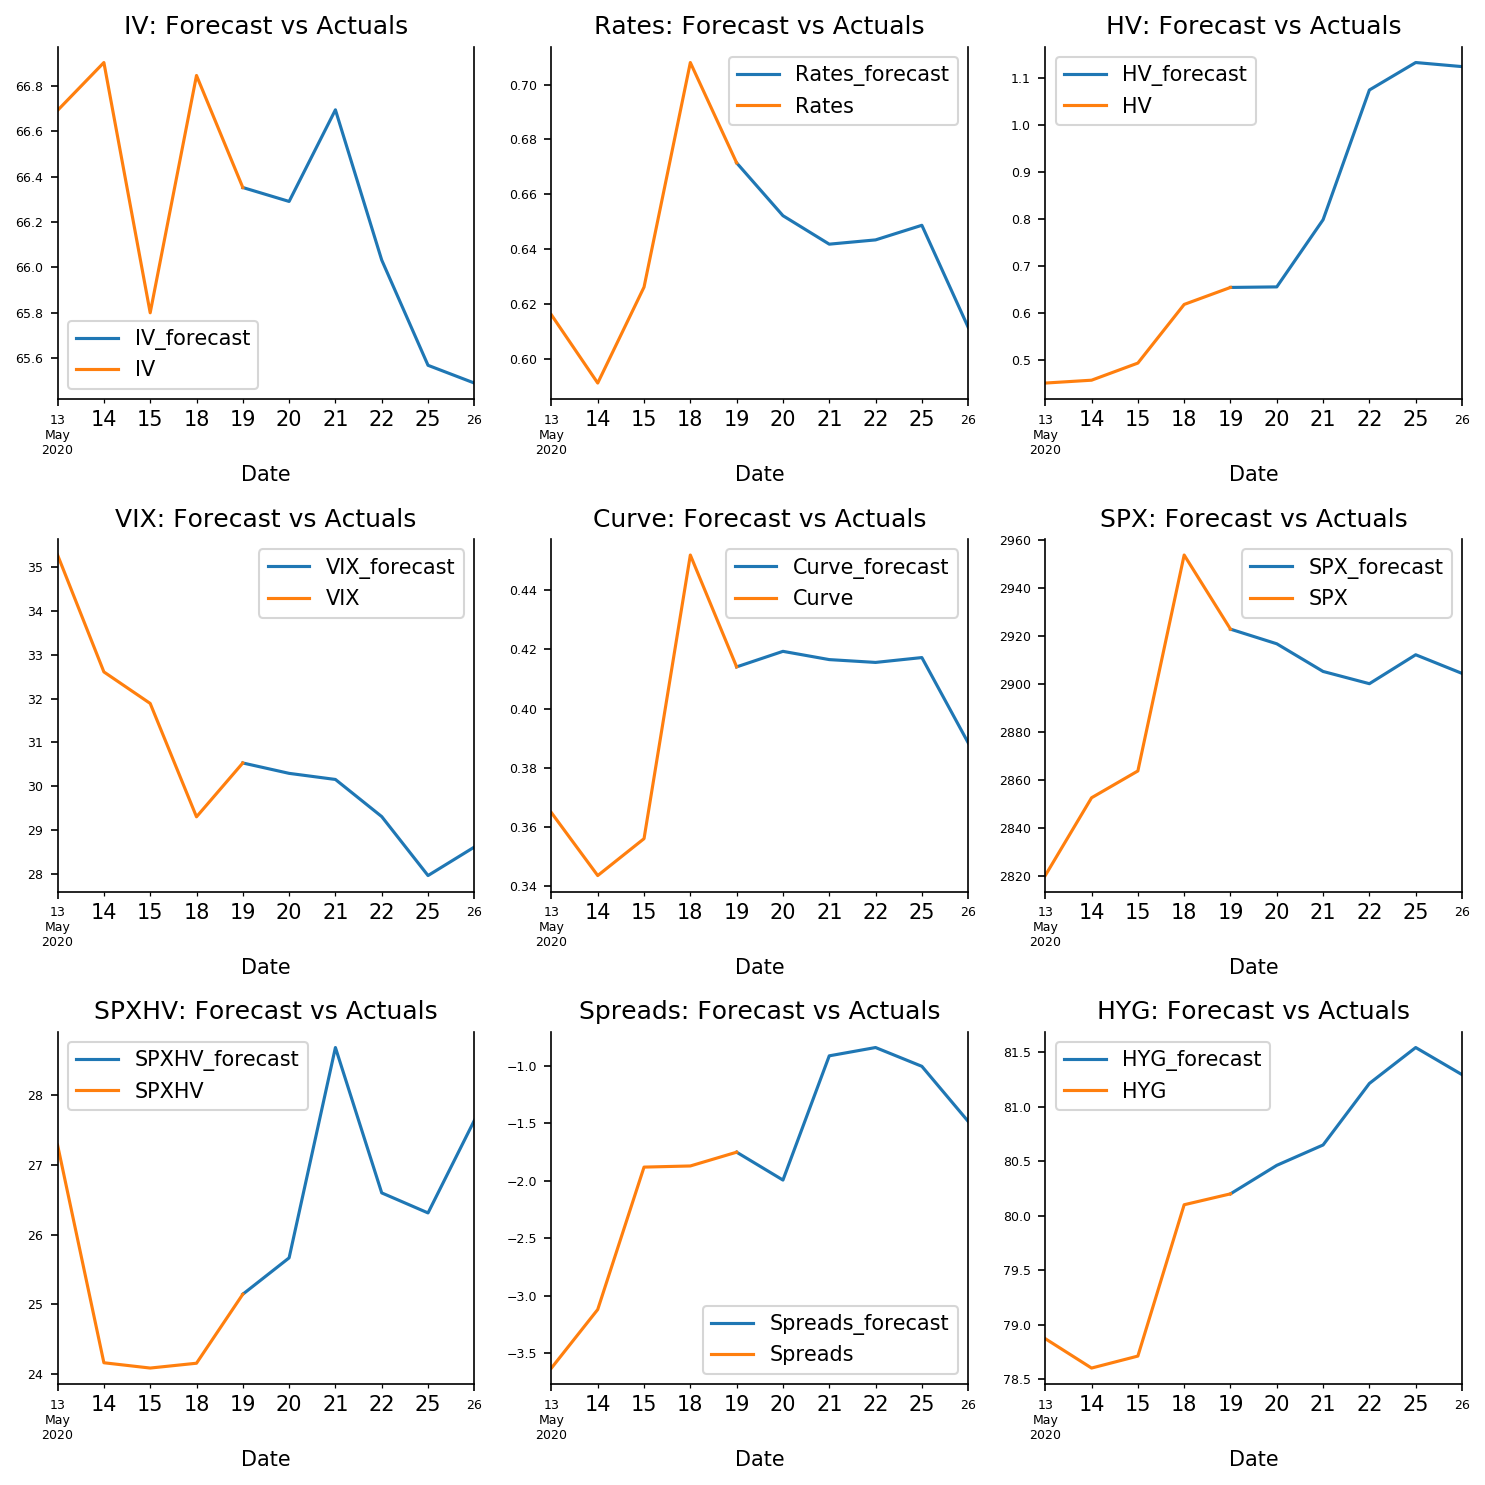

In [57]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/3), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_output[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();